<span style='font-size: 300%; font-weight: bold;'>
<a style="position: fixed; bottom:5%; right:5%;" href="#top">&#8679;</a>
</span>

# Tracking without iTPC hits in Run 18

Compare tracks reconstructed in events with and without hits in sector 14

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mypytk.star as star
import star.utils as stu

In [2]:
uproot.__version__

'3.4.15'

## Define branches to read

In [3]:
branches = {
    'ppx':   'Track.mPMomentumX',
    'ppy':   'Track.mPMomentumY',
    'ppz':   'Track.mPMomentumZ',
    'gpx':   'Track.mGMomentumX',
    'gpy':   'Track.mGMomentumY',
    'gpz':   'Track.mGMomentumZ',
    'nhits': 'Track.mNHitsFit',
    'chi2':  'Track.mChi2',
    'imp':   'TrackCovMatrix.mImp',
    'z':     'TrackCovMatrix.mZ',
    'pti':   'TrackCovMatrix.mPti',
    'tan':   'TrackCovMatrix.mTan',
    'sigma': 'TrackCovMatrix.mSigma[5]',
}

## Define input files

In [4]:
labels = ['YES14', 'NO14']

f_name = lambda label: f'data/genevb/{label}/st_physics_19157003_raw_5500010_more.PicoDst.root'

rootfiles = [f_name(label) for label in labels]
print(f'{len(rootfiles)} file(s)')
rootfiles

2 file(s)


['data/genevb/YES14/st_physics_19157003_raw_5500010_more.PicoDst.root',
 'data/genevb/NO14/st_physics_19157003_raw_5500010_more.PicoDst.root']

## Create dataframe with tracks

Apply the following basic selection to reduce the memory footprint

- track origin in transverse plane < 10 cm ('or')
- track origin in z < 50 cm ('oz')
- track angle w.r.t. xy plane < pi/6 ( 30 degrees) ('polar')

In [5]:
%%time

filt_defs = {
    #'polar': lambda df: np.abs(np.arctan2(df.gpz, np.sqrt(df.gpx**2 + df.gpy**2))) < np.pi/6,
    'or':    lambda df: df.imp < 10,
    'oz':    lambda df: np.abs(df.z) < 50,
}

df, filt_counts = stu.make_df(rootfiles, 'PicoDst', branches, filt_defs)

df.info()
print(filt_counts)
print(np.array(list(filt_counts.values()))/filt_counts['in'])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4062691 entries, (0, 0, 0) to (1, 13214, 0)
Data columns (total 17 columns):
ppx         float32
ppy         float32
ppz         float32
gpx         float32
gpy         float32
gpz         float32
nhits       int8
chi2        uint16
imp         float32
z           float32
pti         float32
tan         float32
sigma[0]    float32
sigma[1]    float32
sigma[2]    float32
sigma[3]    float32
sigma[4]    float32
dtypes: float32(15), int8(1), uint16(1)
memory usage: 263.6 MB
{'or': 9328323, 'oz': 4624688, 'in': 11093476}
[0.84088369 0.41688358 1.        ]
CPU times: user 24.5 s, sys: 4.59 s, total: 29.1 s
Wall time: 19.5 s


In [6]:
%%time

branches_v = {
    'vx':  'Event.mPrimaryVertexX',
    'vy':  'Event.mPrimaryVertexY',
    'vz':  'Event.mPrimaryVertexZ'
}

df_v, filt_counts = stu.make_df(rootfiles, 'PicoDst', branches_v, {})

df_v.info()
print(filt_counts)
print(np.array(list(filt_counts.values()))/filt_counts['in'])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26441 entries, (0, 0, 0) to (1, 13214, 0)
Data columns (total 3 columns):
vx    26441 non-null float32
vy    26441 non-null float32
vz    26441 non-null float32
dtypes: float32(3)
memory usage: 516.7 KB
{'in': 26441}
[1.]
CPU times: user 296 ms, sys: 33.8 ms, total: 329 ms
Wall time: 358 ms


In [7]:
#df_v2 = df_v.reindex(index=df.index, method='bfill')
#df = df.join(df_v2)
df = df.join(df_v.reindex(index=df.index, method='bfill'))
#df
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4062691 entries, (0, 0, 0) to (1, 13214, 0)
Data columns (total 20 columns):
ppx         float32
ppy         float32
ppz         float32
gpx         float32
gpy         float32
gpz         float32
nhits       int8
chi2        uint16
imp         float32
z           float32
pti         float32
tan         float32
sigma[0]    float32
sigma[1]    float32
sigma[2]    float32
sigma[3]    float32
sigma[4]    float32
vx          float32
vy          float32
vz          float32
dtypes: float32(18), int8(1), uint16(1)
memory usage: 470.1 MB


### Add more observables

In [8]:
df = df.assign(
    imp2d=df.imp - np.sqrt(df.vx**2 + df.vy**2),
    imp3d=np.sqrt((df.imp - np.sqrt(df.vx**2 + df.vy**2))**2 + (df.z - df.vz)**2),
    mag=np.sqrt(df.ppx**2 + df.ppy**2 + df.ppz**2),
    ppt=np.sqrt(df.ppx**2 + df.ppy**2),
    gpt=np.sqrt(df.gpx**2 + df.gpy**2),
    tphi=np.arctan2(df.gpy, df.gpx),
    teta=star.pseudorapidity(df.gpx, df.gpy, df.gpz),
    sector=star.tpc_sectors(np.arctan2(df.gpy, df.gpx), half='east')
)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4062691 entries, (0, 0, 0) to (1, 13214, 0)
Data columns (total 28 columns):
ppx         float32
ppy         float32
ppz         float32
gpx         float32
gpy         float32
gpz         float32
nhits       int8
chi2        uint16
imp         float32
z           float32
pti         float32
tan         float32
sigma[0]    float32
sigma[1]    float32
sigma[2]    float32
sigma[3]    float32
sigma[4]    float32
vx          float32
vy          float32
vz          float32
imp2d       float32
imp3d       float32
mag         float32
ppt         float32
gpt         float32
tphi        float32
teta        float32
sector      int64
dtypes: float32(25), int64(1), int8(1), uint16(1)
memory usage: 449.6 MB


## Create filters for tracks

In [9]:
is_primary = lambda df: df.mag > 0
#print(is_primary(df).sum())

is_primary_east = lambda df: is_primary(df) & (df.teta < 0) & (df.oz < 0)
#print(is_primary_east(df).sum())

is_primary_west = lambda df: is_primary(df) & (df.teta > 0) & (df.oz > 0)
#print(is_primary_west(df).sum())

# We are mainly interested in the East side with iTPC sector
points_east = lambda df: (df.teta < 0) & (df.z < 0)
#print(points_east(df).sum())

points_west = lambda df: (df.teta > 0) & (df.z > 0)
#print(points_west(df).sum())

in_pt_bin = lambda df, pt_min, pt_max: (df.gpt > pt_min) & (df.gpt < pt_max)
#in_sector = lambda df, sector: (df.tphi > star.TPC_SECTORS_EAST[sector][0]) & (df.tphi < star.TPC_SECTORS_EAST[sector][1])
in_sector = lambda df, sector: (df.sector == sector)

## Preselected dataframes

In [10]:
idx = pd.IndexSlice
yes14 = idx[0,:,:]
no14  = idx[1,:,:]

df_Y = df.loc[yes14]
df_N = df.loc[no14]

points_east_Y = points_east(df_Y)
points_east_N = points_east(df_N)

is_primary_Y = is_primary(df_Y)
is_primary_N = is_primary(df_N)

### Masks for different $P_T$ bins

In [11]:
nbins_pt = 10
edges_pt = np.linspace(0.1, 1, nbins_pt)
edges_pt = np.append(edges_pt, np.inf)

in_pt_bin_Y = {}
in_pt_bin_N = {}
for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    in_pt_bin_Y[i] = in_pt_bin(df_Y, pt_min, pt_max)
    in_pt_bin_N[i] = in_pt_bin(df_N, pt_min, pt_max)
    #print( np.sum(in_pt_bin_Y[i]), np.sum(in_pt_bin_N[i]) )

## Plot track parameters for different $P_T$ bins

## YES14 vs NO14 datasets for all/global and primary tracks

### Track $\phi$ vs $\eta$

### Track $\phi$ vs $\eta$, narrow $\eta$

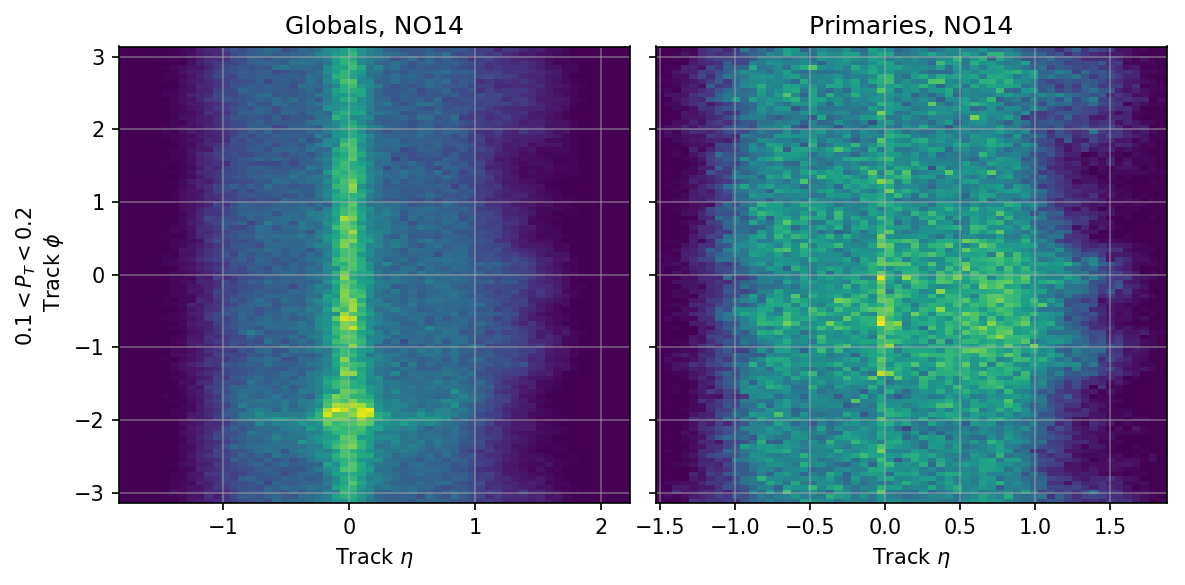

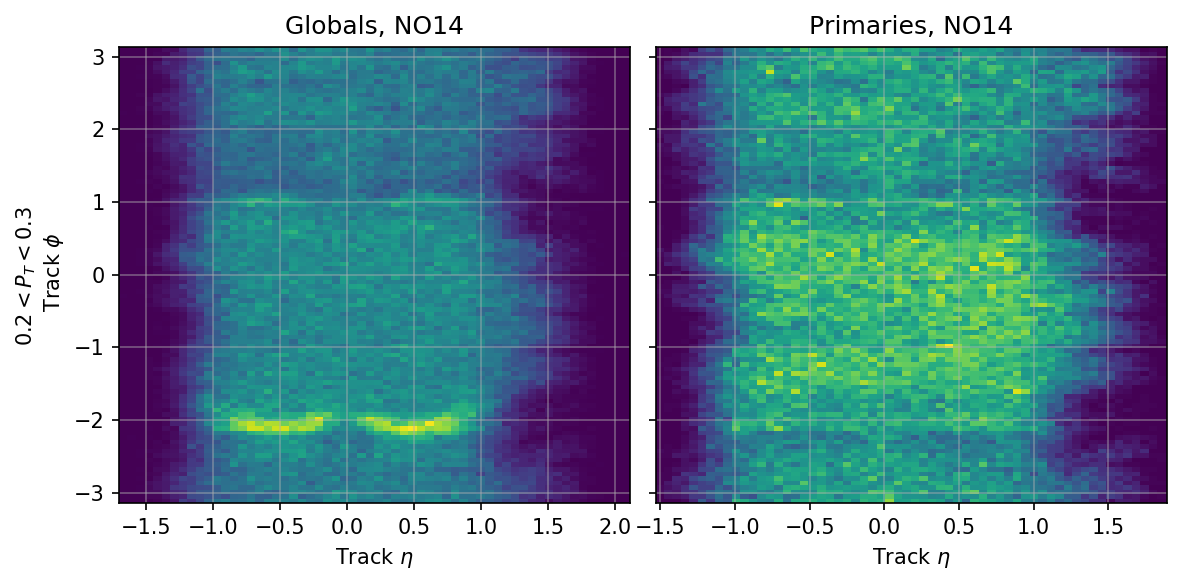

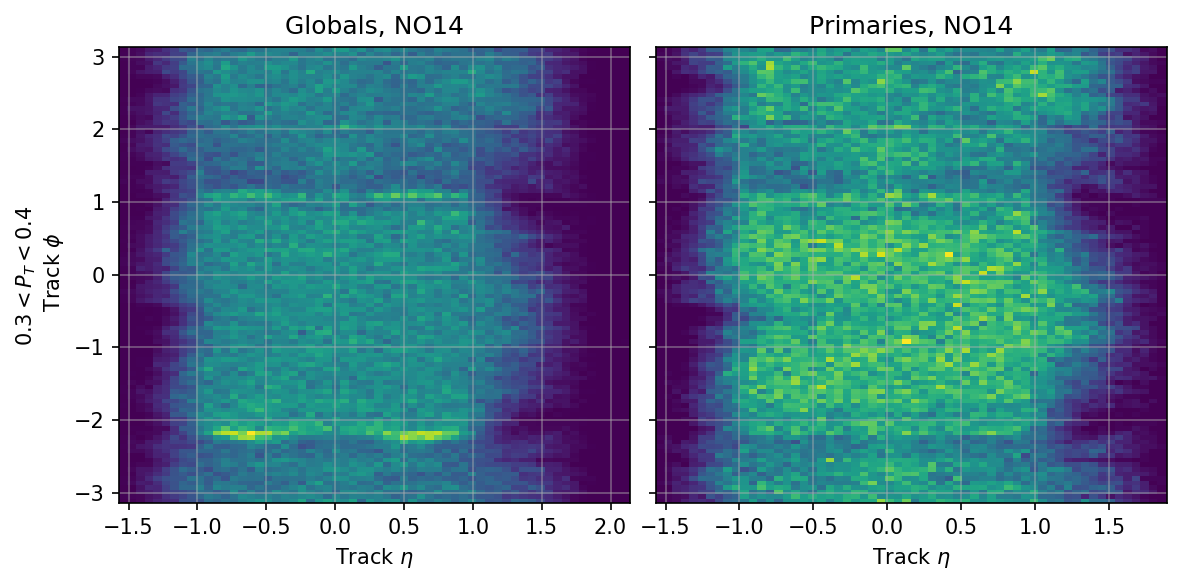

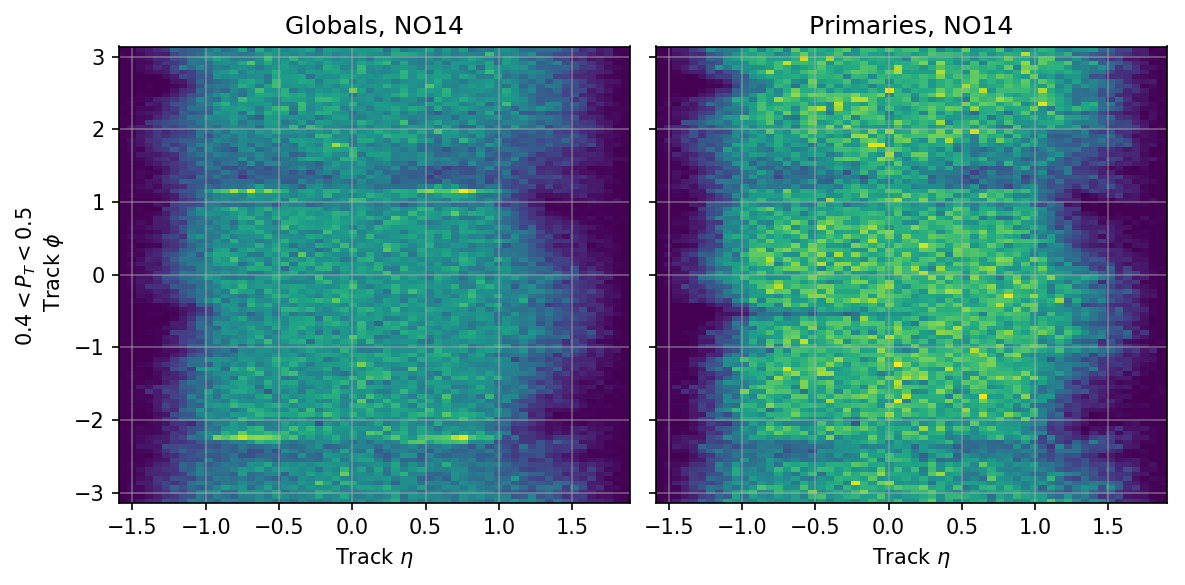

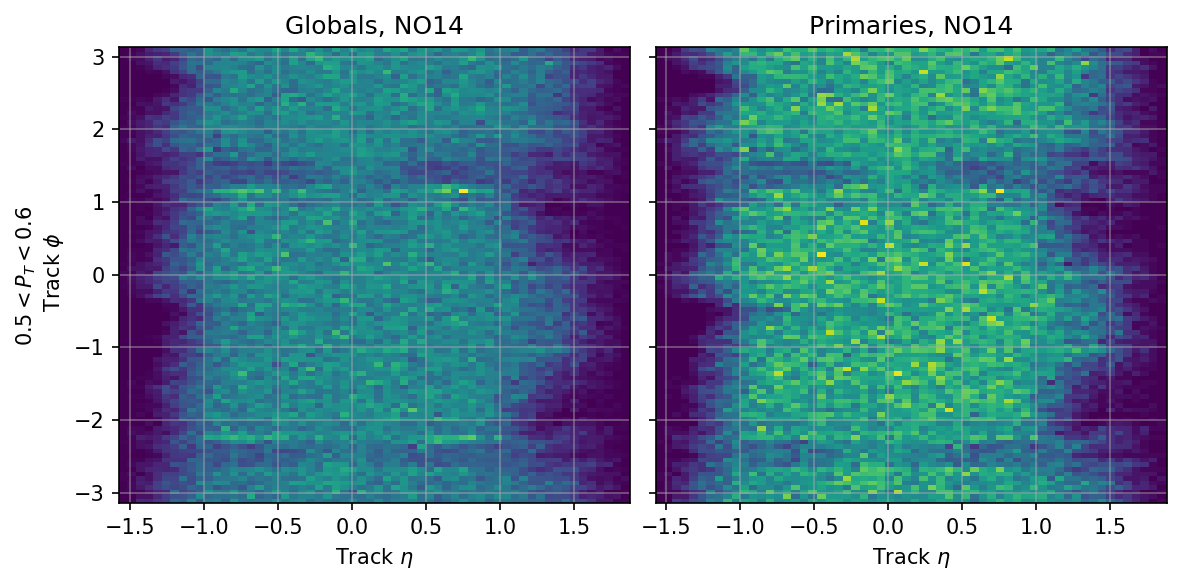

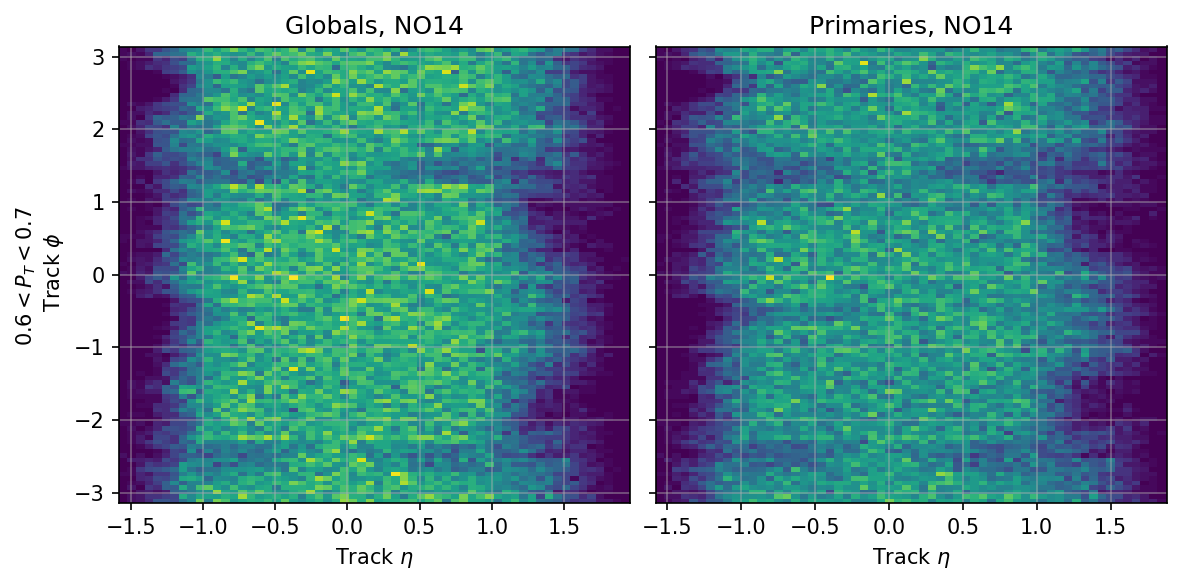

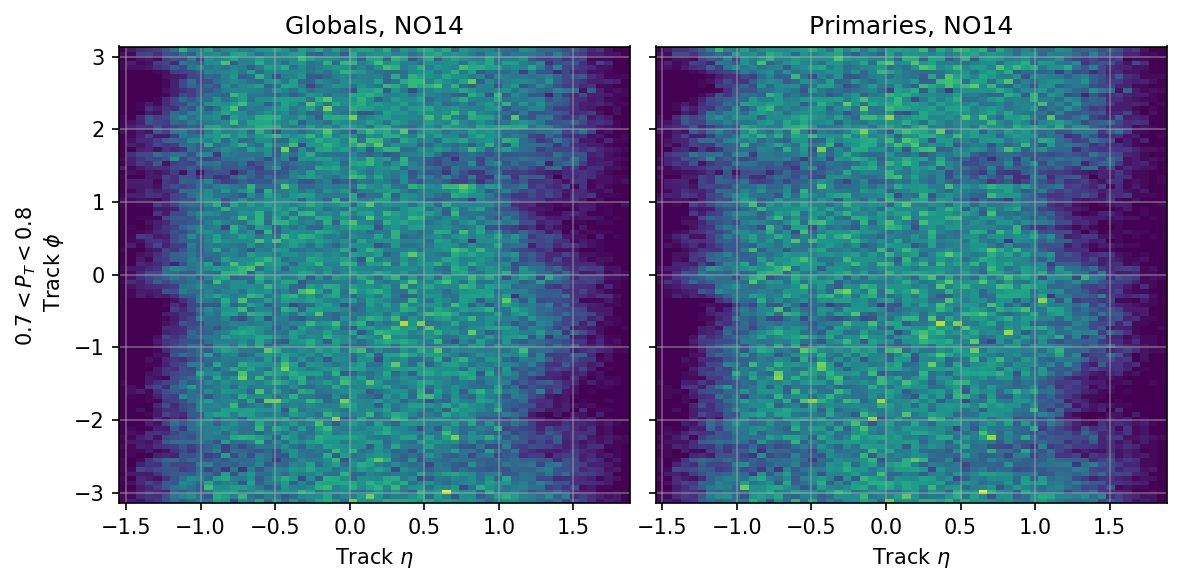

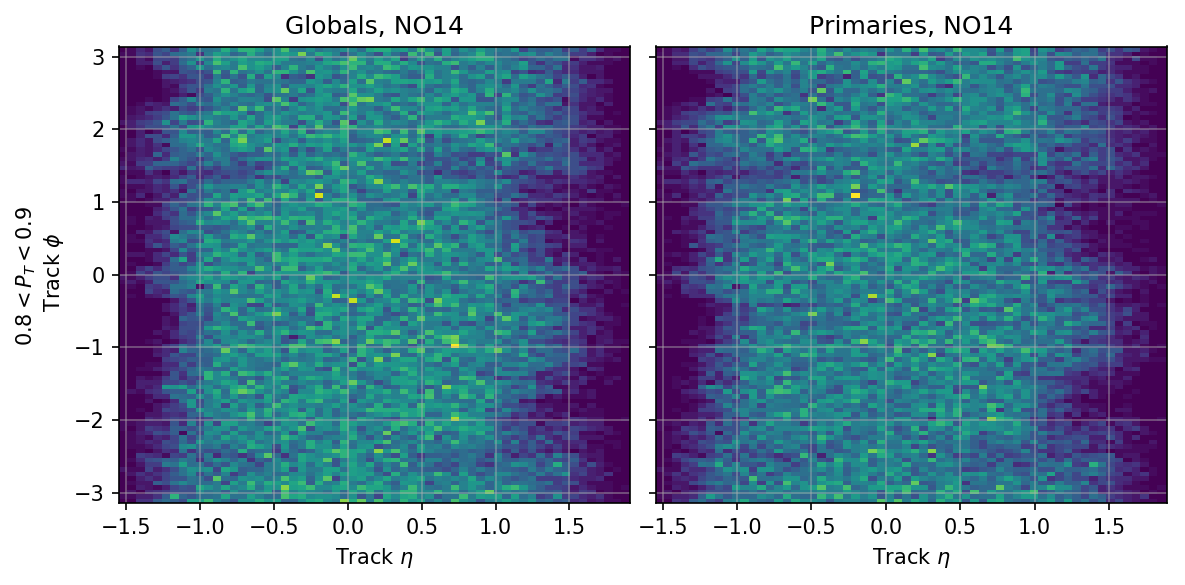

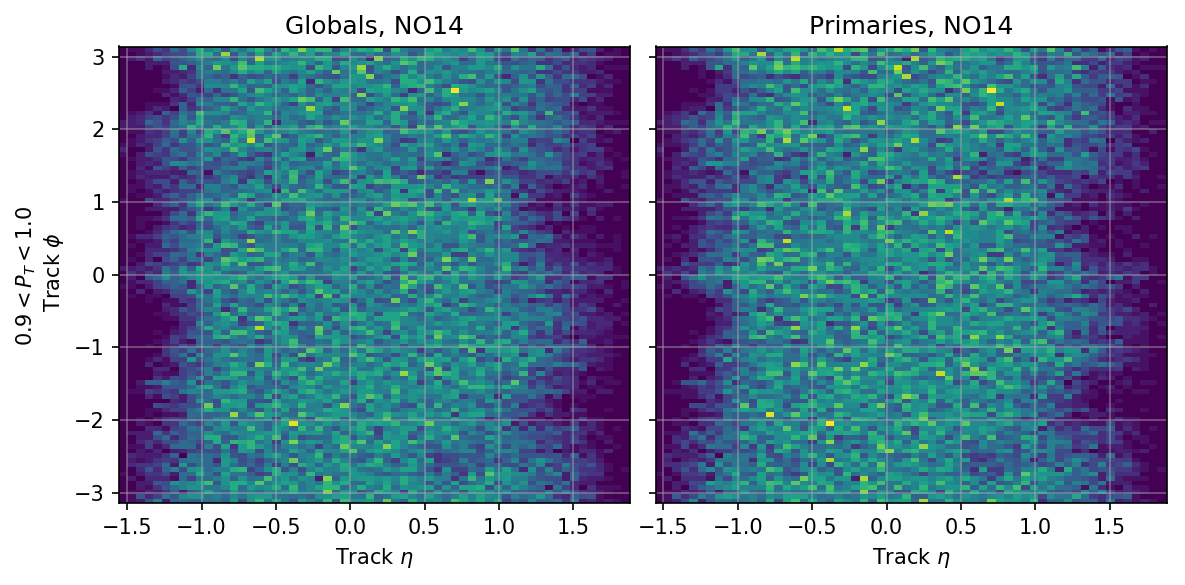

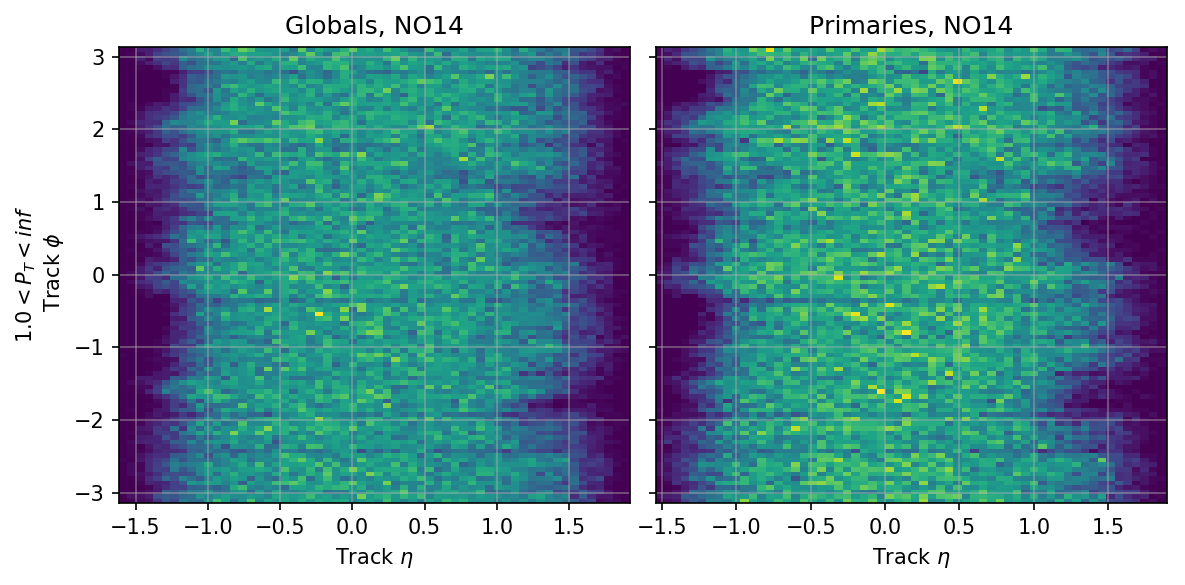

In [12]:
#fig, ax = plt.subplots(nbins_pt, 4, figsize=(10, 2.5*nbins_pt), sharey='row', sharex='col')

#h_kwargs = dict(bins=[60, 100], norm=mpl.colors.LogNorm())
h_kwargs = dict(bins=[60, 100])

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='row')#, , sharex='col')

    #select = in_pt_bin(df_Y, pt_min, pt_max)
#
    #a = ax[i, 0]
    #h = a.hist2d(df_Y.loc[ select ].teta, df_Y.loc[ select ].tphi, **h_kwargs)
    #a.set_title('Globals, YES14') if i == 0 else None
    #a.set_xlabel('Track $\eta$') if i == nbins_pt-1 else None
    #a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$ \n Track $\phi$')
    #a.grid()
    #
    #select = is_primary_Y & in_pt_bin(df_Y, pt_min, pt_max)
#
    #a = ax[i, 1]
    #h = a.hist2d(df_Y.loc[ select ].teta, df_Y.loc[ select ].tphi, **h_kwargs)
    #a.set_title('Primaries, YES14') if i == 0 else None
    #a.set_xlabel('Track $\eta$') if i == nbins_pt-1 else None
    #a.grid()

    select = in_pt_bin(df_N, pt_min, pt_max)

    a = ax[0]
    h = a.hist2d(df_N.loc[ select ].teta, df_N.loc[ select ].tphi, **h_kwargs)
    a.set_title('Globals, NO14')# if i == 0 else None
    a.set_xlabel('Track $\eta$')# if i == nbins_pt-1 else None
    a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$ \n Track $\phi$')
    a.grid()

    select = is_primary_N & in_pt_bin(df_N, pt_min, pt_max)

    a = ax[1]
    h = a.hist2d(df_N.loc[ select ].teta, df_N.loc[ select ].tphi, **h_kwargs)
    a.set_title('Primaries, NO14') #if i == 0 else None
    a.set_xlabel('Track $\eta$')   #if i == nbins_pt-1 else None
    a.grid()

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    #plt.show()
    plt.savefig(f'graphics/phi_vs_eta_pt_bin_{i}.png', bbox_inches='tight', pad_inches=0.1)

### Track $\phi$ distributions for all and primary tracks

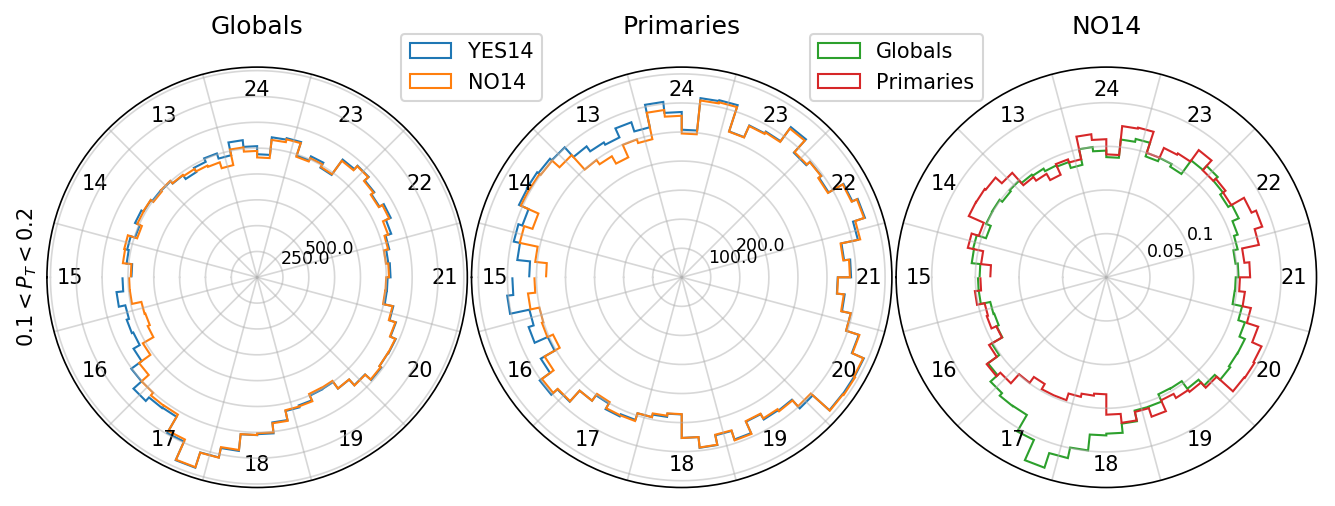

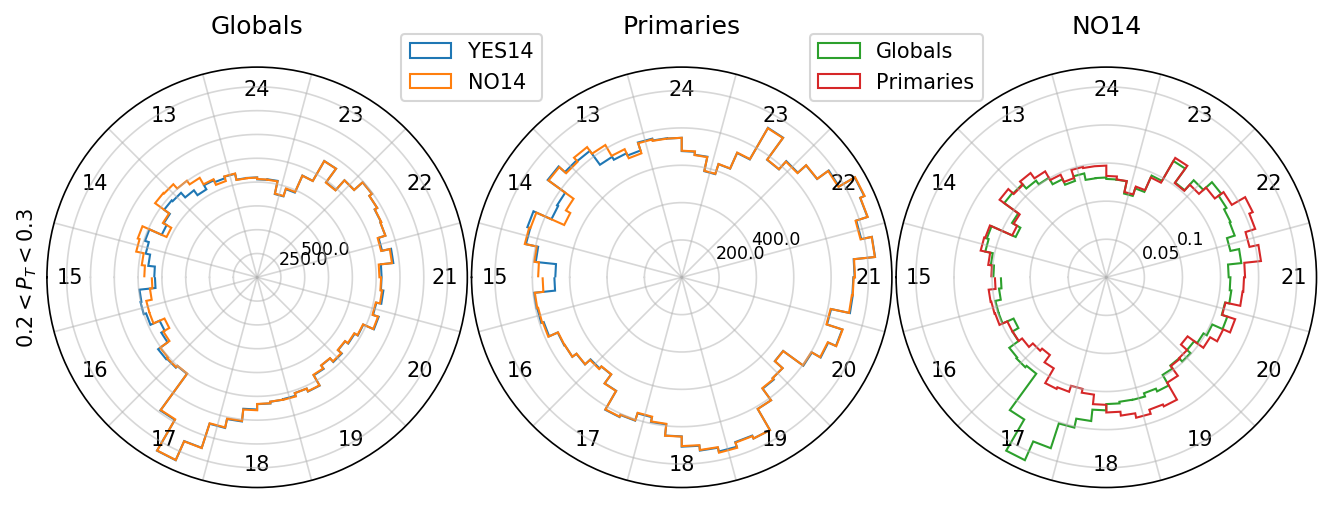

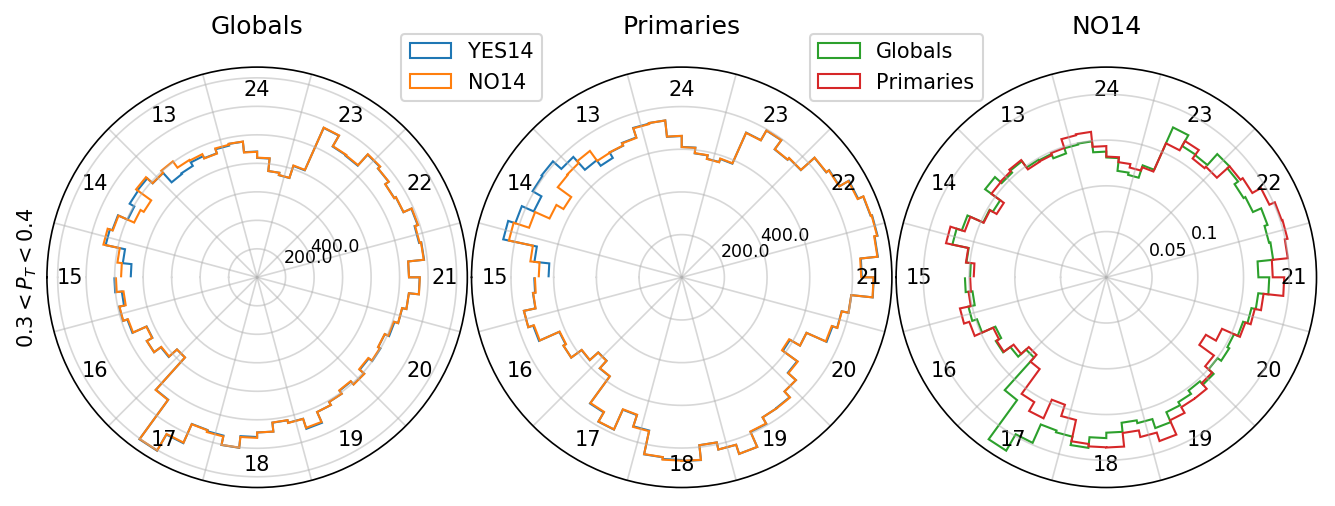

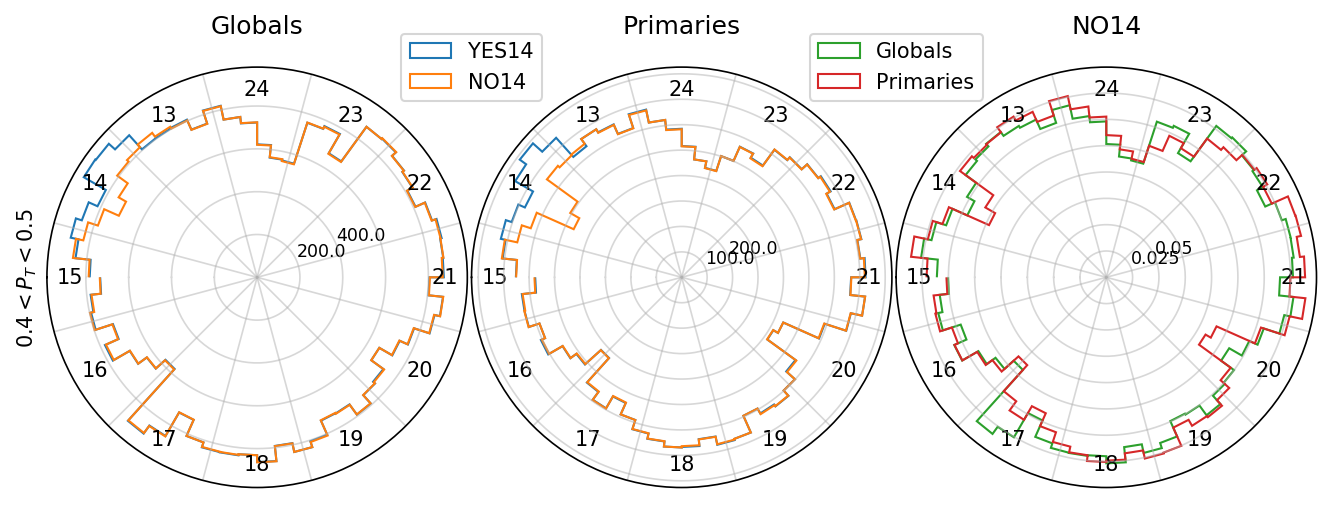

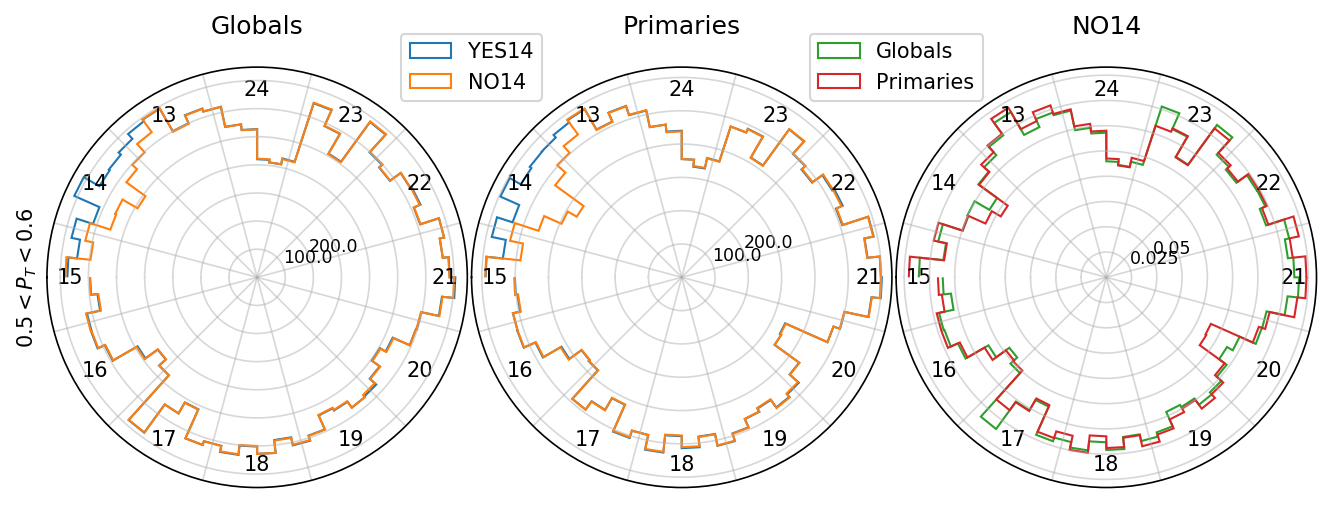

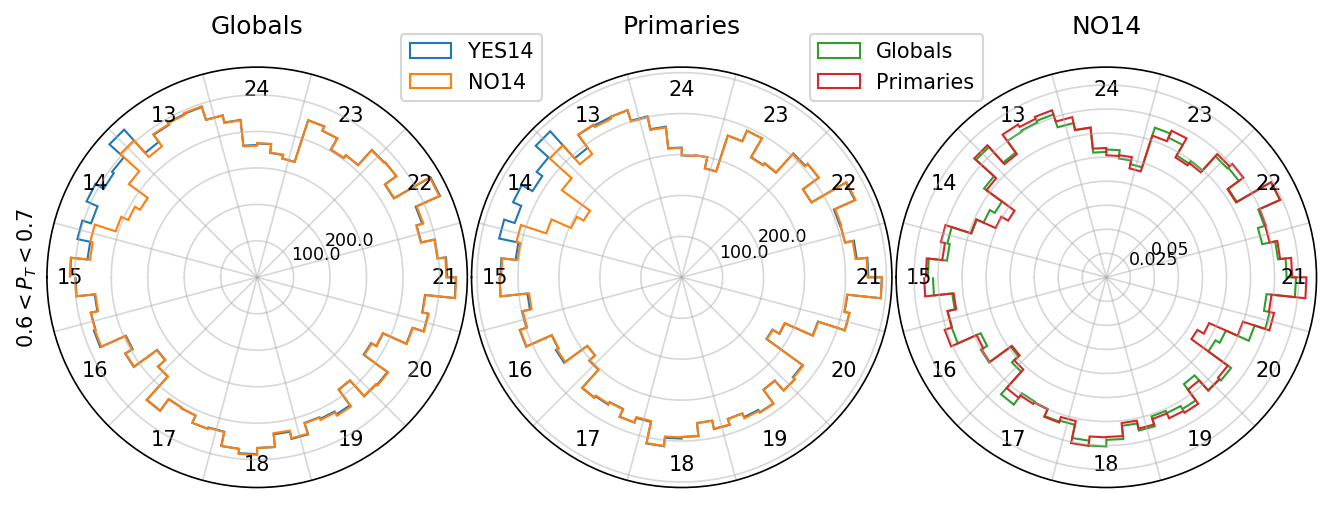

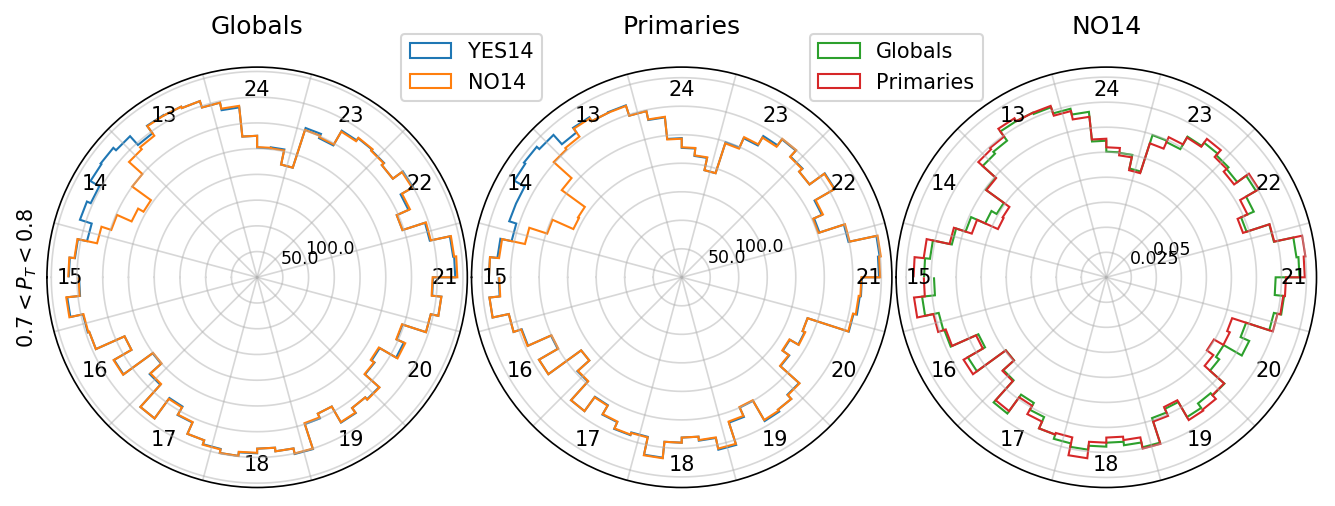

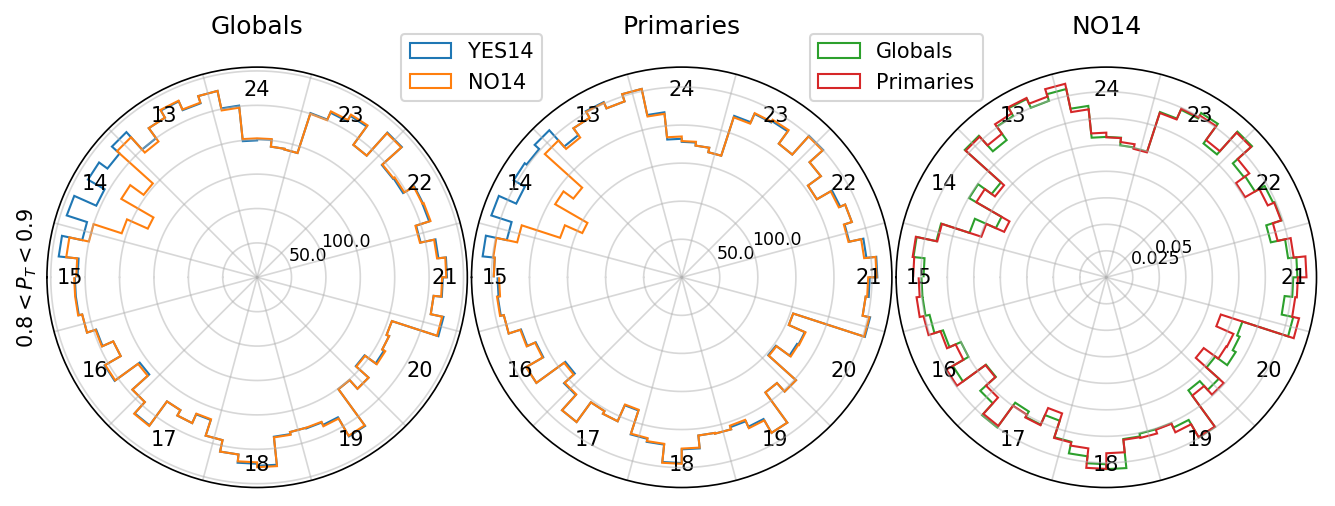

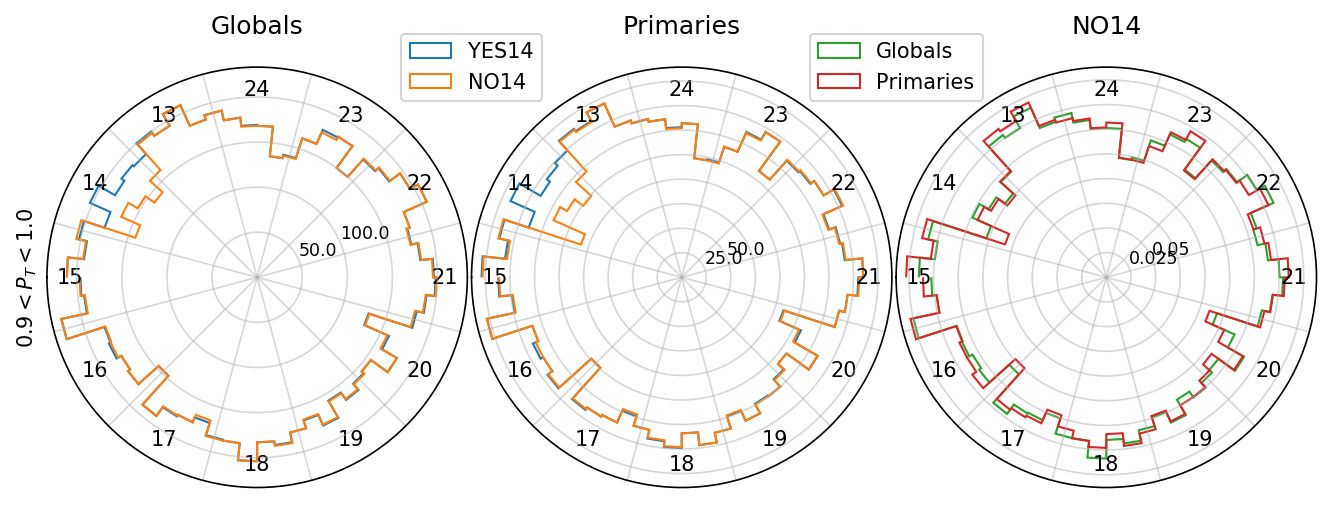

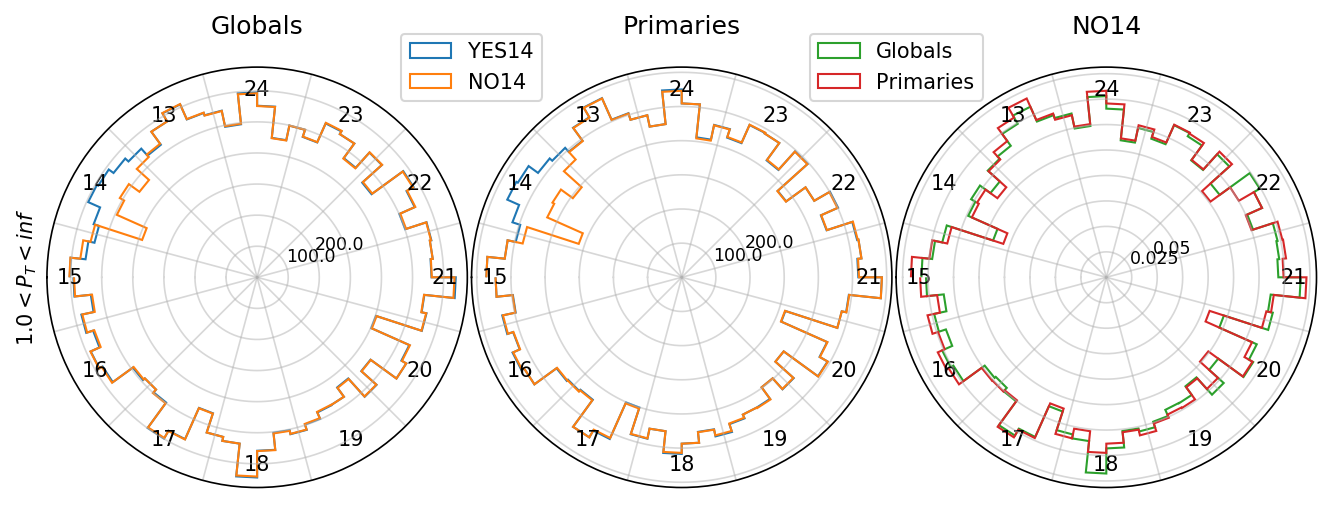

In [13]:
subplot_kw = dict(projection='polar')
#fig, ax = plt.subplots(nbins_pt, 3, figsize=(9, 4*nbins_pt), subplot_kw=subplot_kw)

h_kwargs = dict(bins=np.linspace(-np.pi, np.pi, 61), histtype='step')

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
 
    fig, ax = plt.subplots(1, 3, figsize=(9, 4), subplot_kw=subplot_kw)
    #in_pt_bin_Y = in_pt_bin(df_Y, pt_min, pt_max)
    #in_pt_bin_N = in_pt_bin(df_N, pt_min, pt_max)

    select_Y = points_east_Y & in_pt_bin_Y[i]
    select_N = points_east_N & in_pt_bin_N[i]

    #a = ax[i, 0]
    a = ax[0]
    a.hist(df_Y.loc[ select_Y ].tphi, label='YES14', **h_kwargs)
    a.hist(df_N.loc[ select_N ].tphi, label='NO14', **h_kwargs)
    
    a.set_title('Globals')# if i == 0 else None
    a.set_xticklabels([])
    a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    star.tpc_grid(a, star.TPC_SECTOR_IDS_EAST, -20)
    
    a = ax[2]
    a.hist(df_N.loc[ select_N ].tphi, label='Globals', density=True, color='C2', **h_kwargs)

    # Now constrain to primary tracks
    select_Y = select_Y & is_primary_Y
    select_N = select_N & is_primary_N

    a = ax[1]
    a.hist(df_Y.loc[ select_Y ].tphi, label='YES14', **h_kwargs)
    a.hist(df_N.loc[ select_N ].tphi, label='NO14', **h_kwargs)
    
    a.set_title('Primaries')# if i == 0 else None
    a.set_xticklabels([])
    a.legend(bbox_to_anchor=(0,1), loc="center", borderaxespad=0)
    star.tpc_grid(a, star.TPC_SECTOR_IDS_EAST, -20)

    a = ax[2]
    a.hist(df_N.loc[ select_N ].tphi, label='Primaries', density=True, color='C3', **h_kwargs)
    
    a.set_title('NO14')# if i == 0 else None
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.legend(bbox_to_anchor=(0,1), loc="center")
    star.tpc_grid(a, star.TPC_SECTOR_IDS_EAST, -20)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    #plt.show()
    plt.savefig(f'graphics/phi_pt_bin_{i}.png', bbox_inches='tight', pad_inches=0.1)

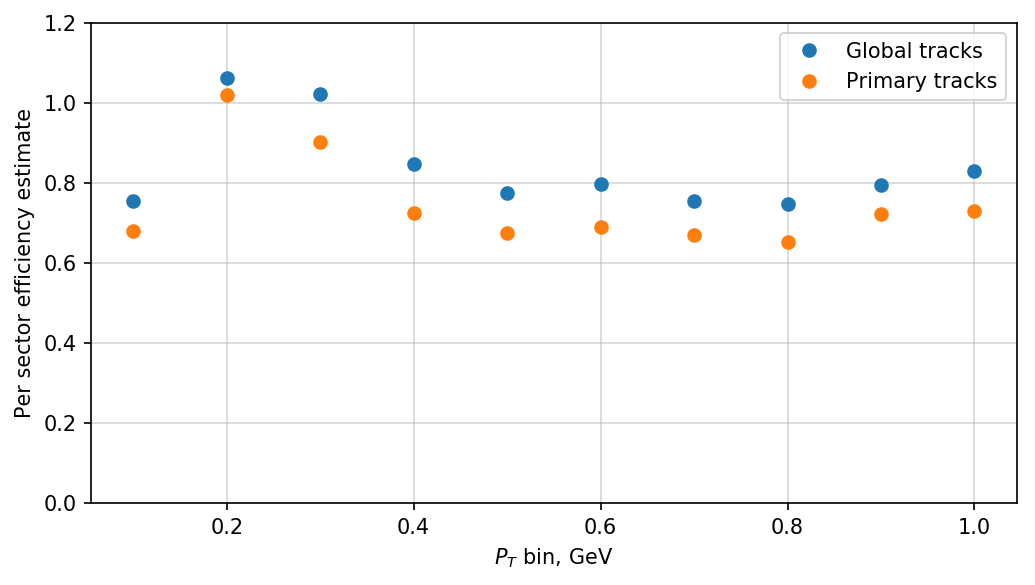

In [14]:
eff_globals = np.zeros(nbins_pt)
eff_primaries = np.zeros(nbins_pt)

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    select_Y = points_east_Y & in_pt_bin_Y[i]
    select_N = points_east_N & in_pt_bin_N[i]
    eff_globals[i] = len(df_N.loc[select_N].index)/len(df_Y.loc[ select_Y ].index)

    select_Y = select_Y & is_primary_Y
    select_N = select_N & is_primary_N
    eff_primaries[i] = len(df_N.loc[select_N].index)/len(df_Y.loc[ select_Y ].index)
     
# Average per sector efficiency
eff_globals = eff_globals*12 - 11
eff_primaries = eff_primaries*12 - 11


fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.plot(edges_pt[:-1], eff_globals, 'o', label='Global tracks')
ax.plot(edges_pt[:-1], eff_primaries, 'o', label='Primary tracks')
ax.set_ylim(0, 1.2)
ax.set_xlabel('$P_T$ bin, GeV')
ax.set_ylabel('Per sector efficiency estimate')
ax.legend()
ax.grid()

plt.tight_layout()
plt.savefig('graphics/eff_by_pt_bin.png')

## 2D and 3D impact parameters of all tracks

In [15]:
def plot_YN(var, axes, axes_cumul, pt_bin, sector, show_eff, h_kwargs, h_kwargs_cumul):

    if var == 'imp':   xvar = ''
    if var == 'imp2d': xvar = ' 2D'
    if var == 'imp3d': xvar = ' 3D'

    xlabel = f'Track Impact Parameter{xvar}, cm'

    select_Y = points_east_Y & in_pt_bin_Y[pt_bin] & in_sector(df_Y, sector)
    select_N = points_east_N & in_pt_bin_N[pt_bin] & in_sector(df_N, sector)

    a = axes
    a.hist(abs(df_Y.loc[ select_Y ][var]), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ][var]), label='NO14', **h_kwargs)
    a.plot([3, 3], a.get_ylim(), 'C7-', lw=1)
    a.set_title(f'Sector {sector}')
    a.set_xlabel(xlabel)
    a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.grid()
    a.legend(loc='upper right') if show_eff else None
    
    a = axes_cumul
    v1, e1, _ = a.hist(abs(df_Y.loc[ select_Y ][var]), label='S18, YES14', **h_kwargs_cumul)
    v2, e2, _ = a.hist(abs(df_N.loc[ select_N ][var]), label='S18, NO14', **h_kwargs_cumul)
    
    ibin3cm = np.argmax(e1>=3)
    eff = v2[ibin3cm]/v1[ibin3cm]
    
    a.plot([3, 3], a.get_ylim(), 'C7-', lw=1)
    a.set_xlabel(xlabel)
    a.set_ylabel('Cumulative')
    a.grid()
    if show_eff:
        a.text(0, 1.1, f'Exp\'ed primary/global eff.: {eff:.2f}')
    a.legend(loc='lower right')

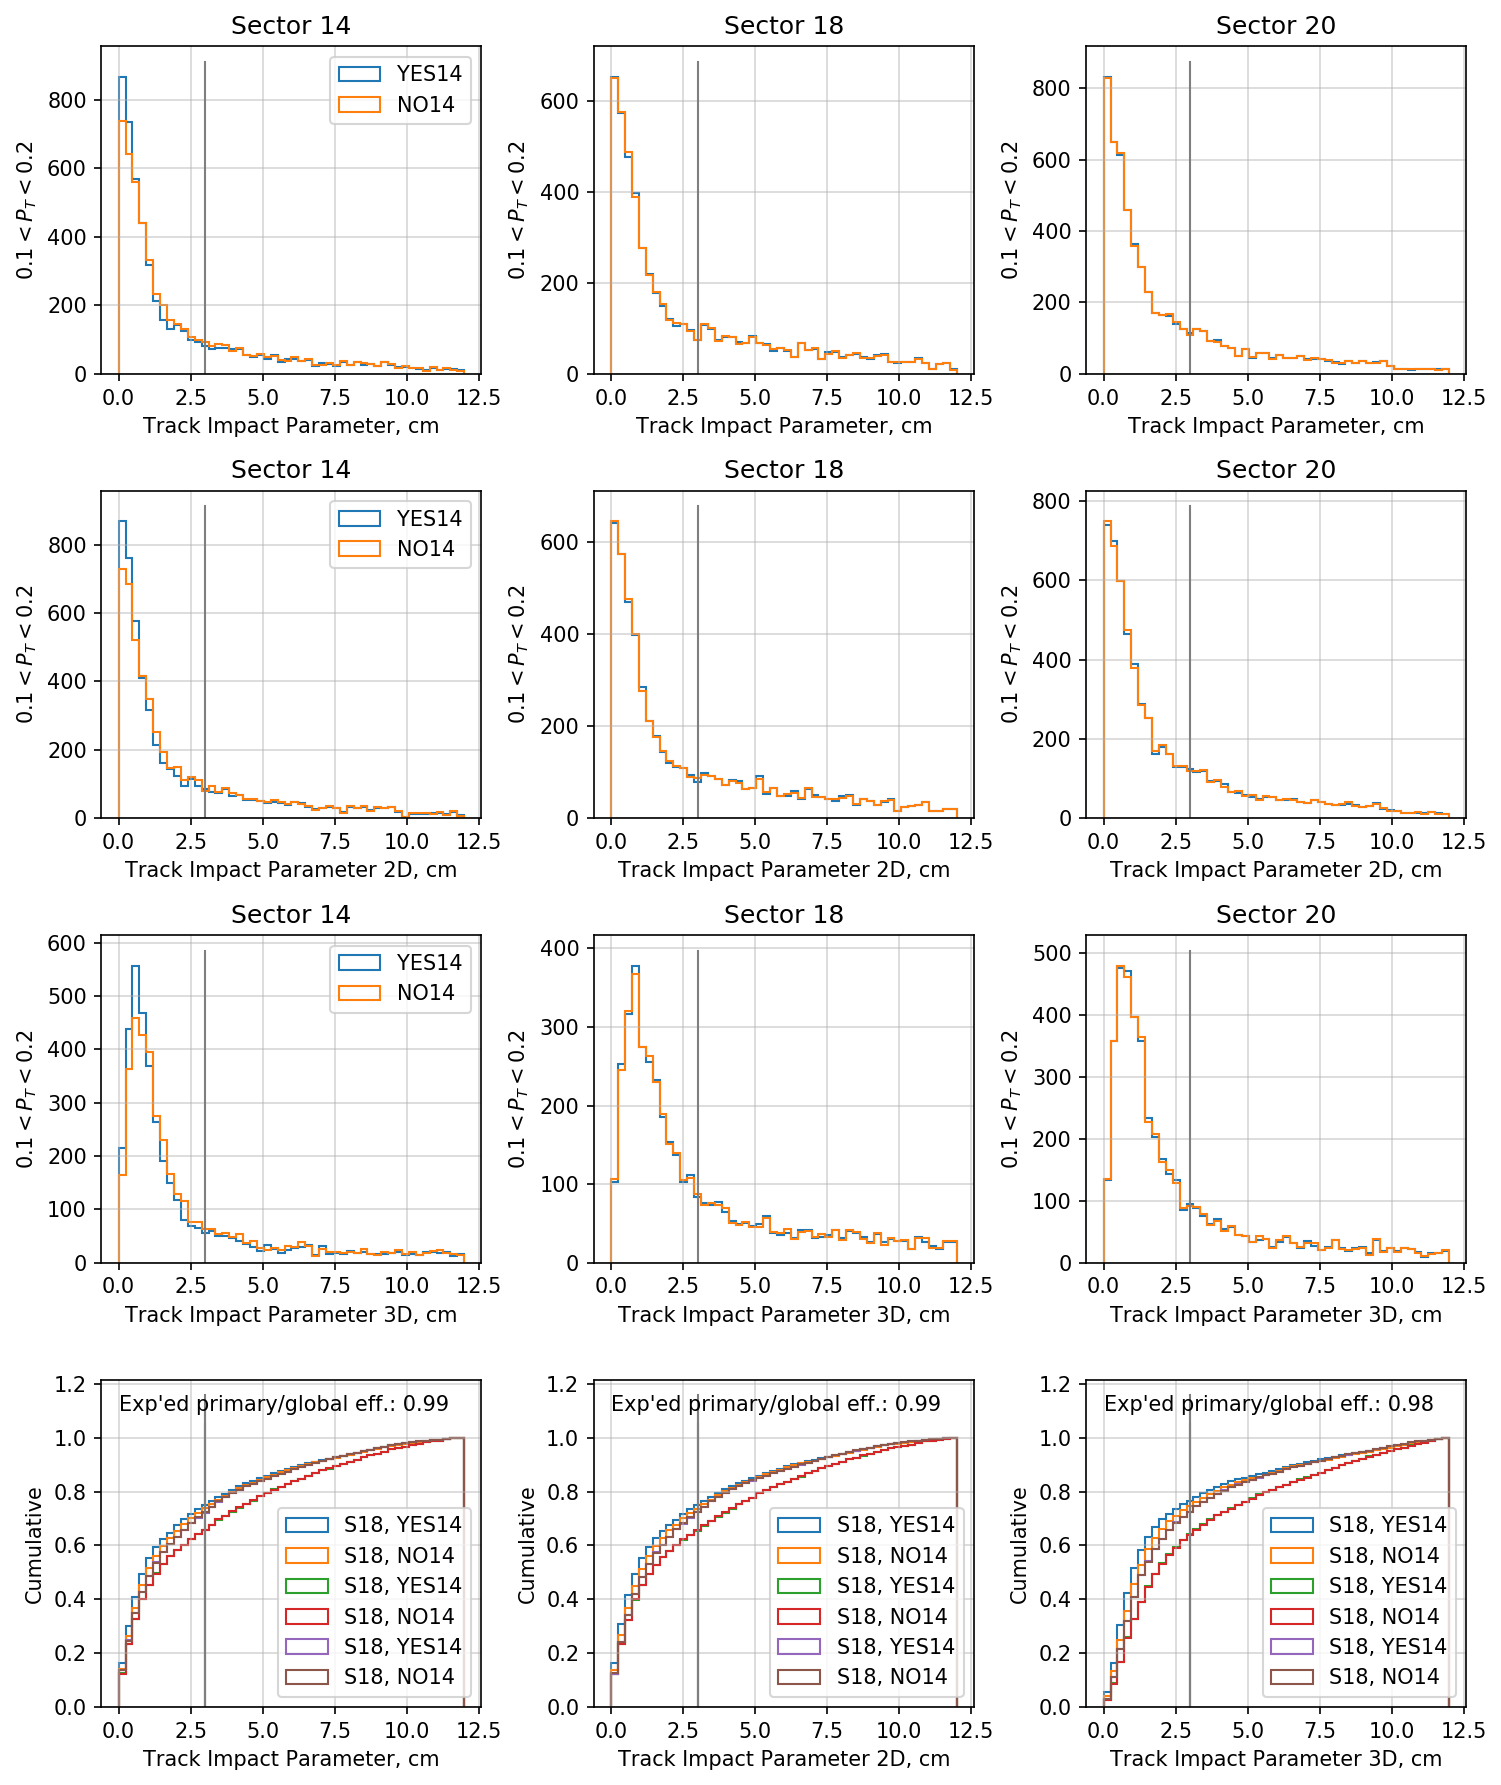

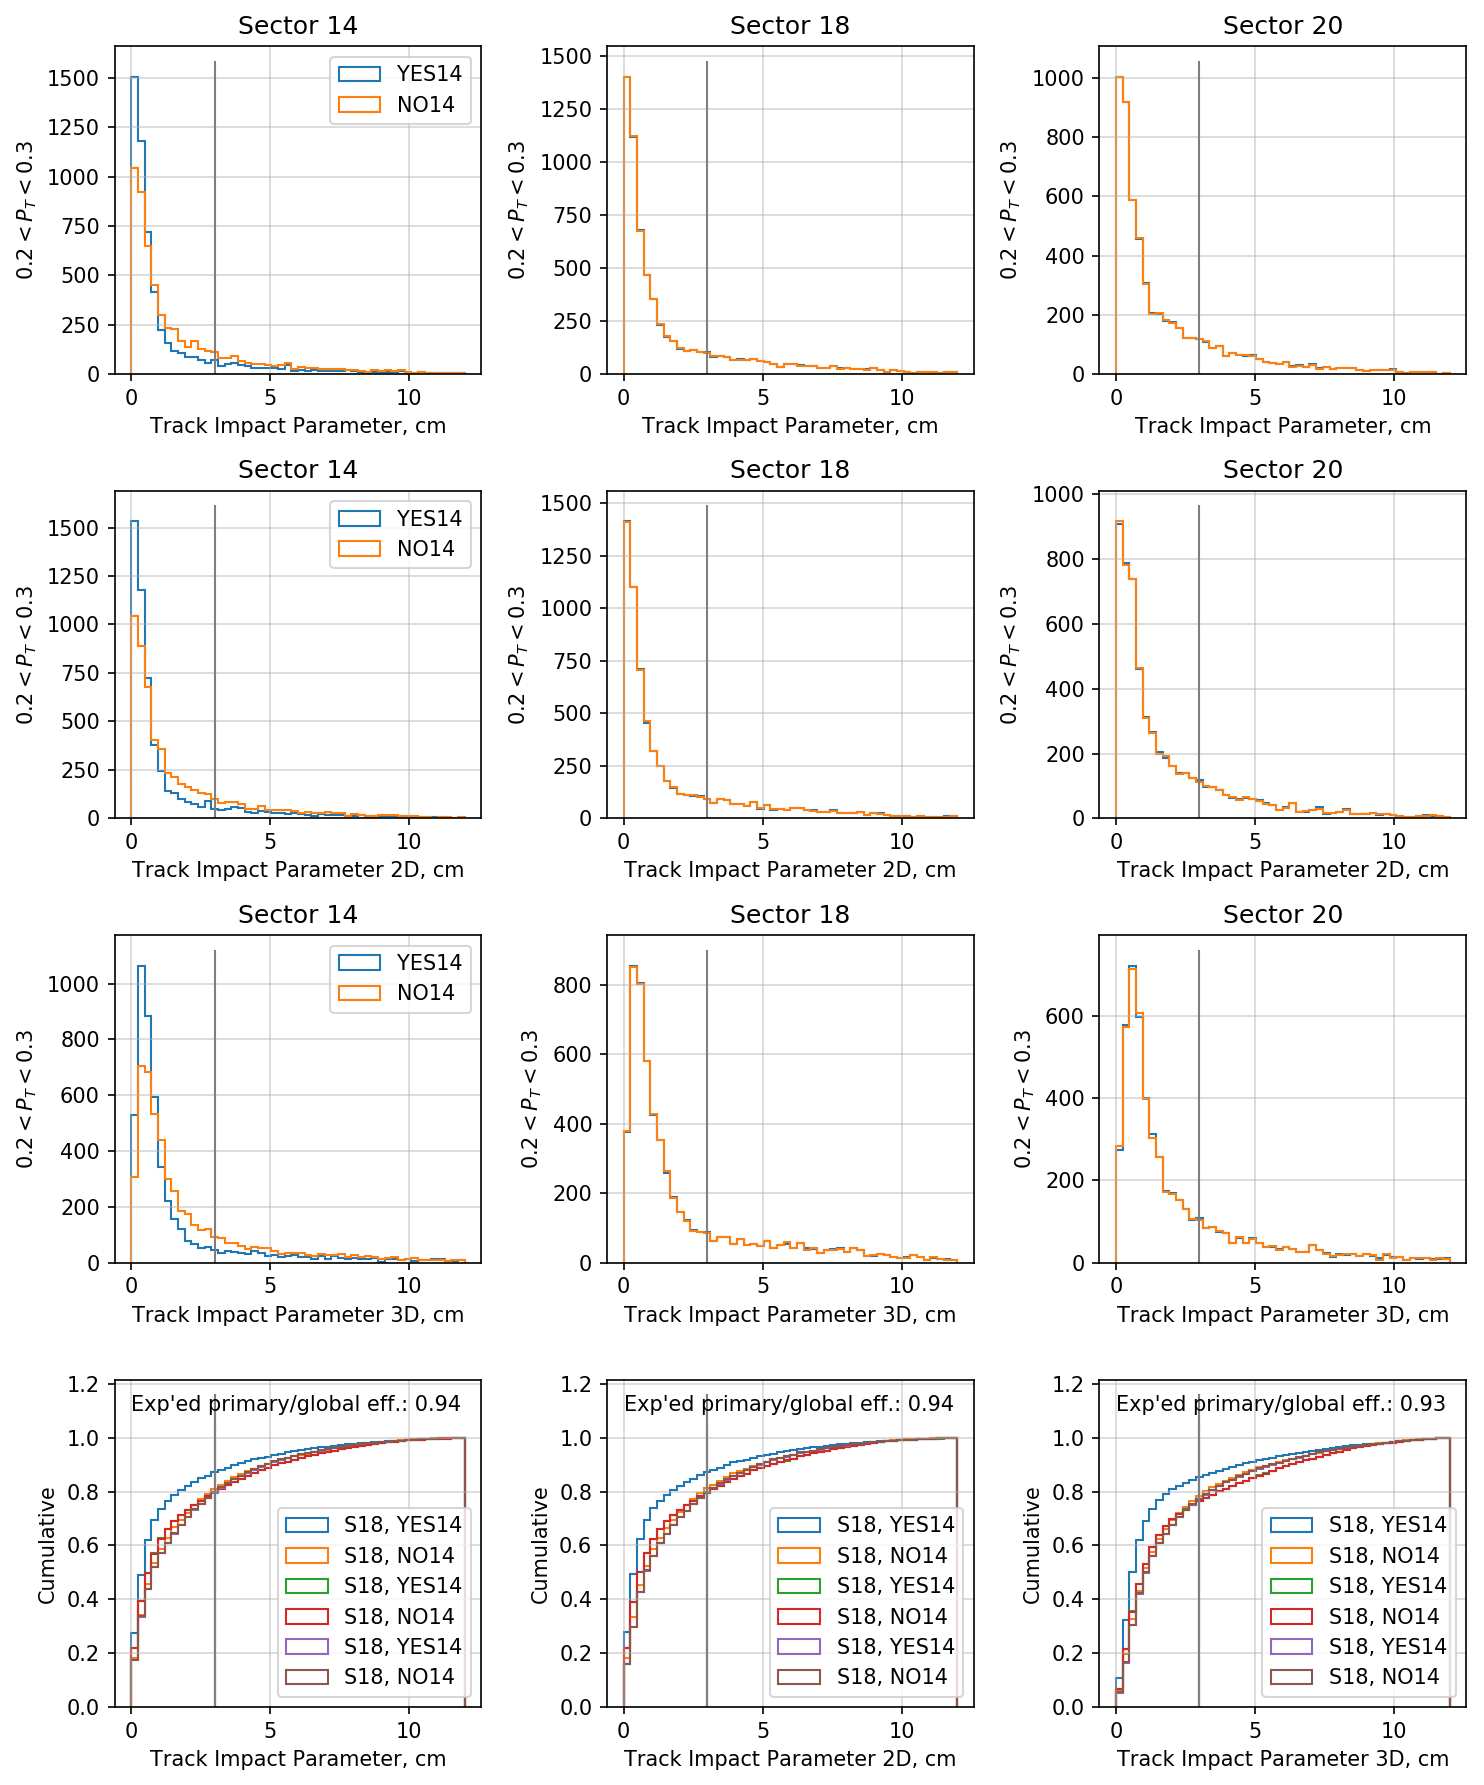

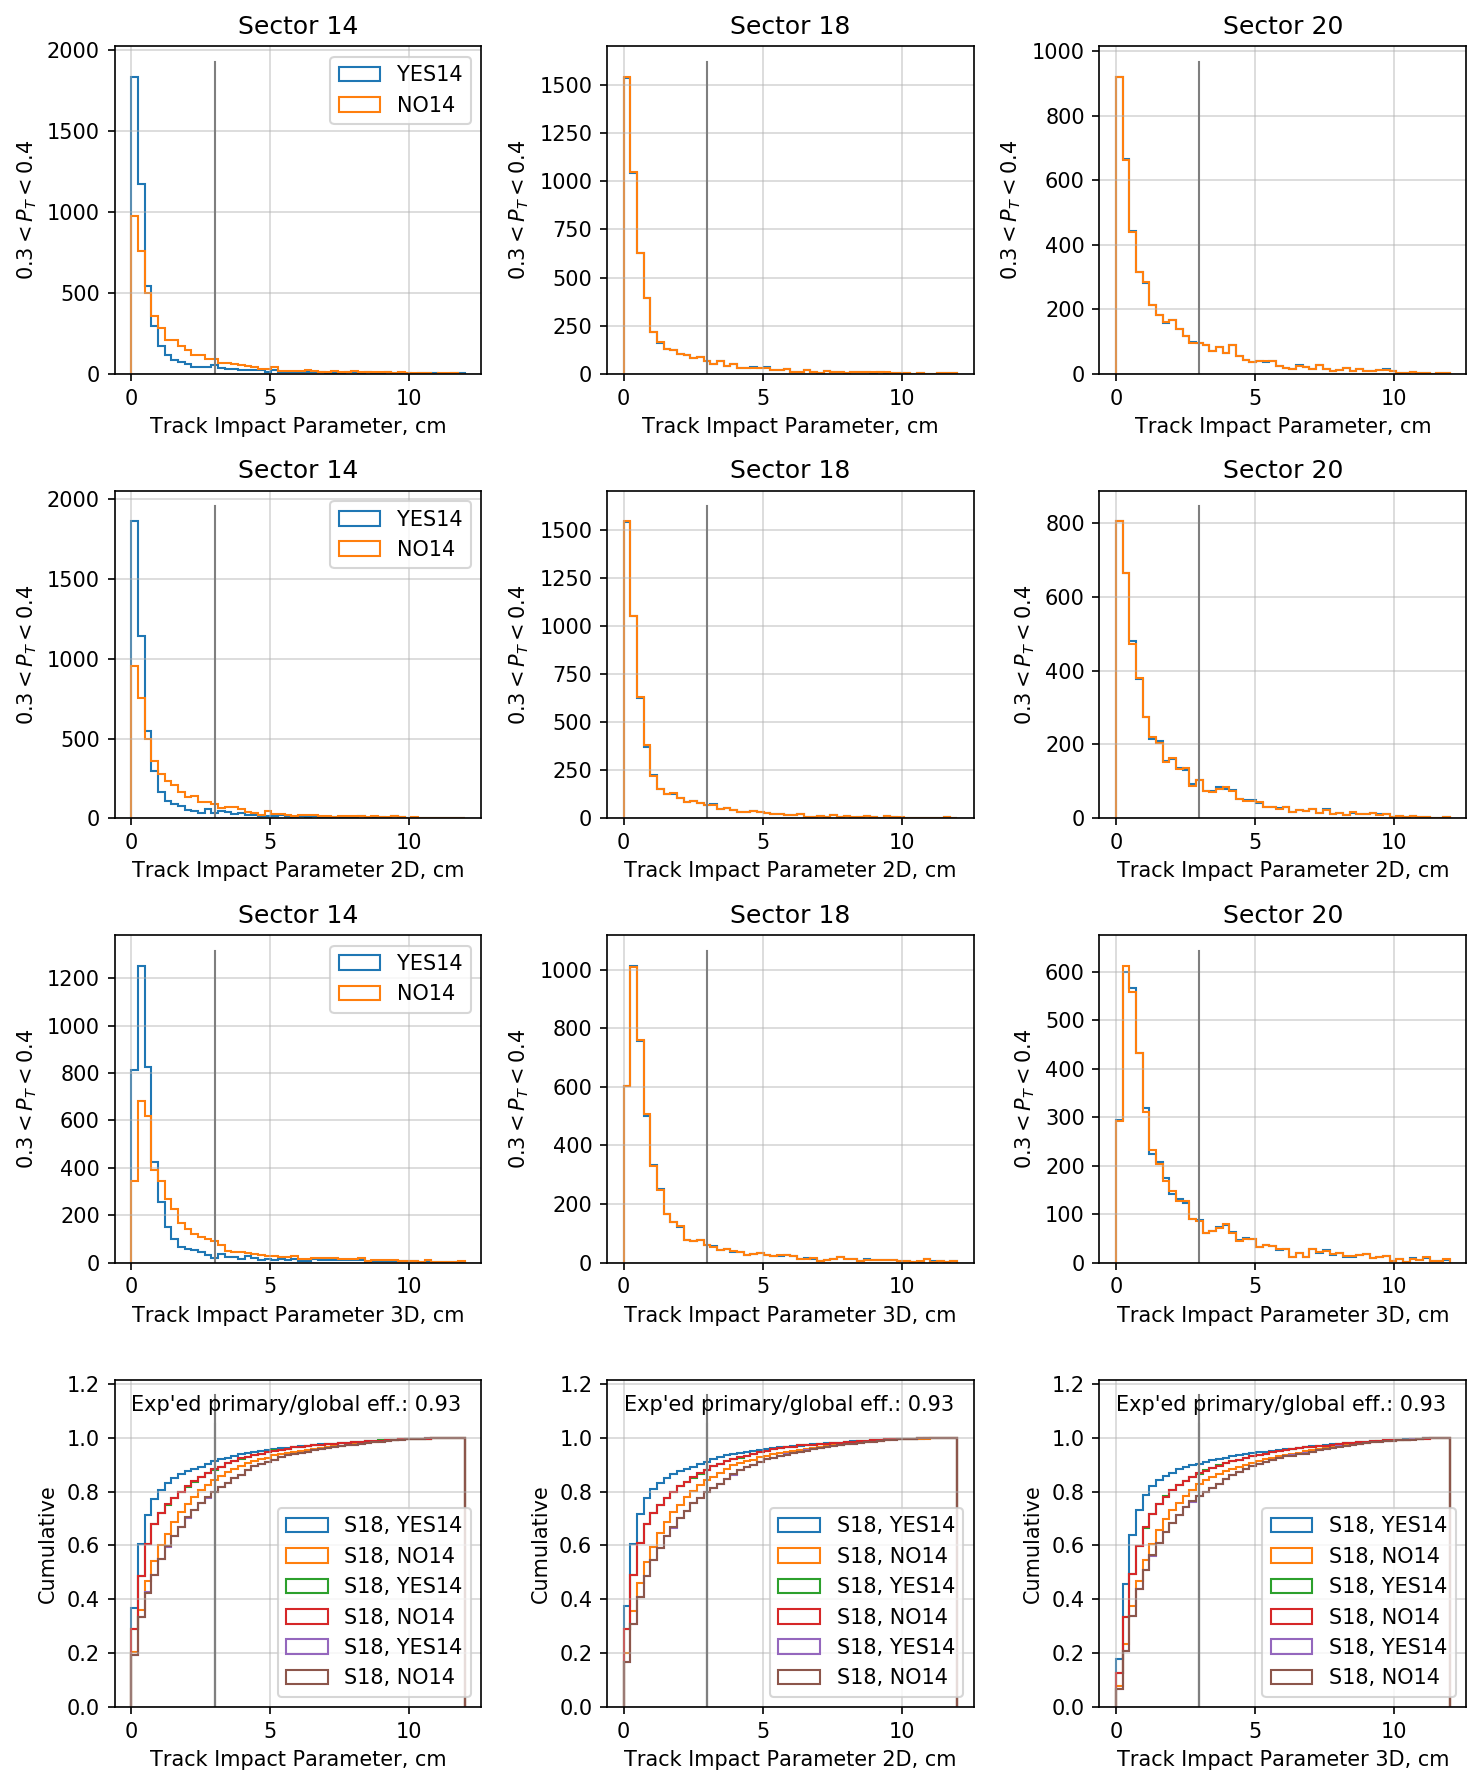

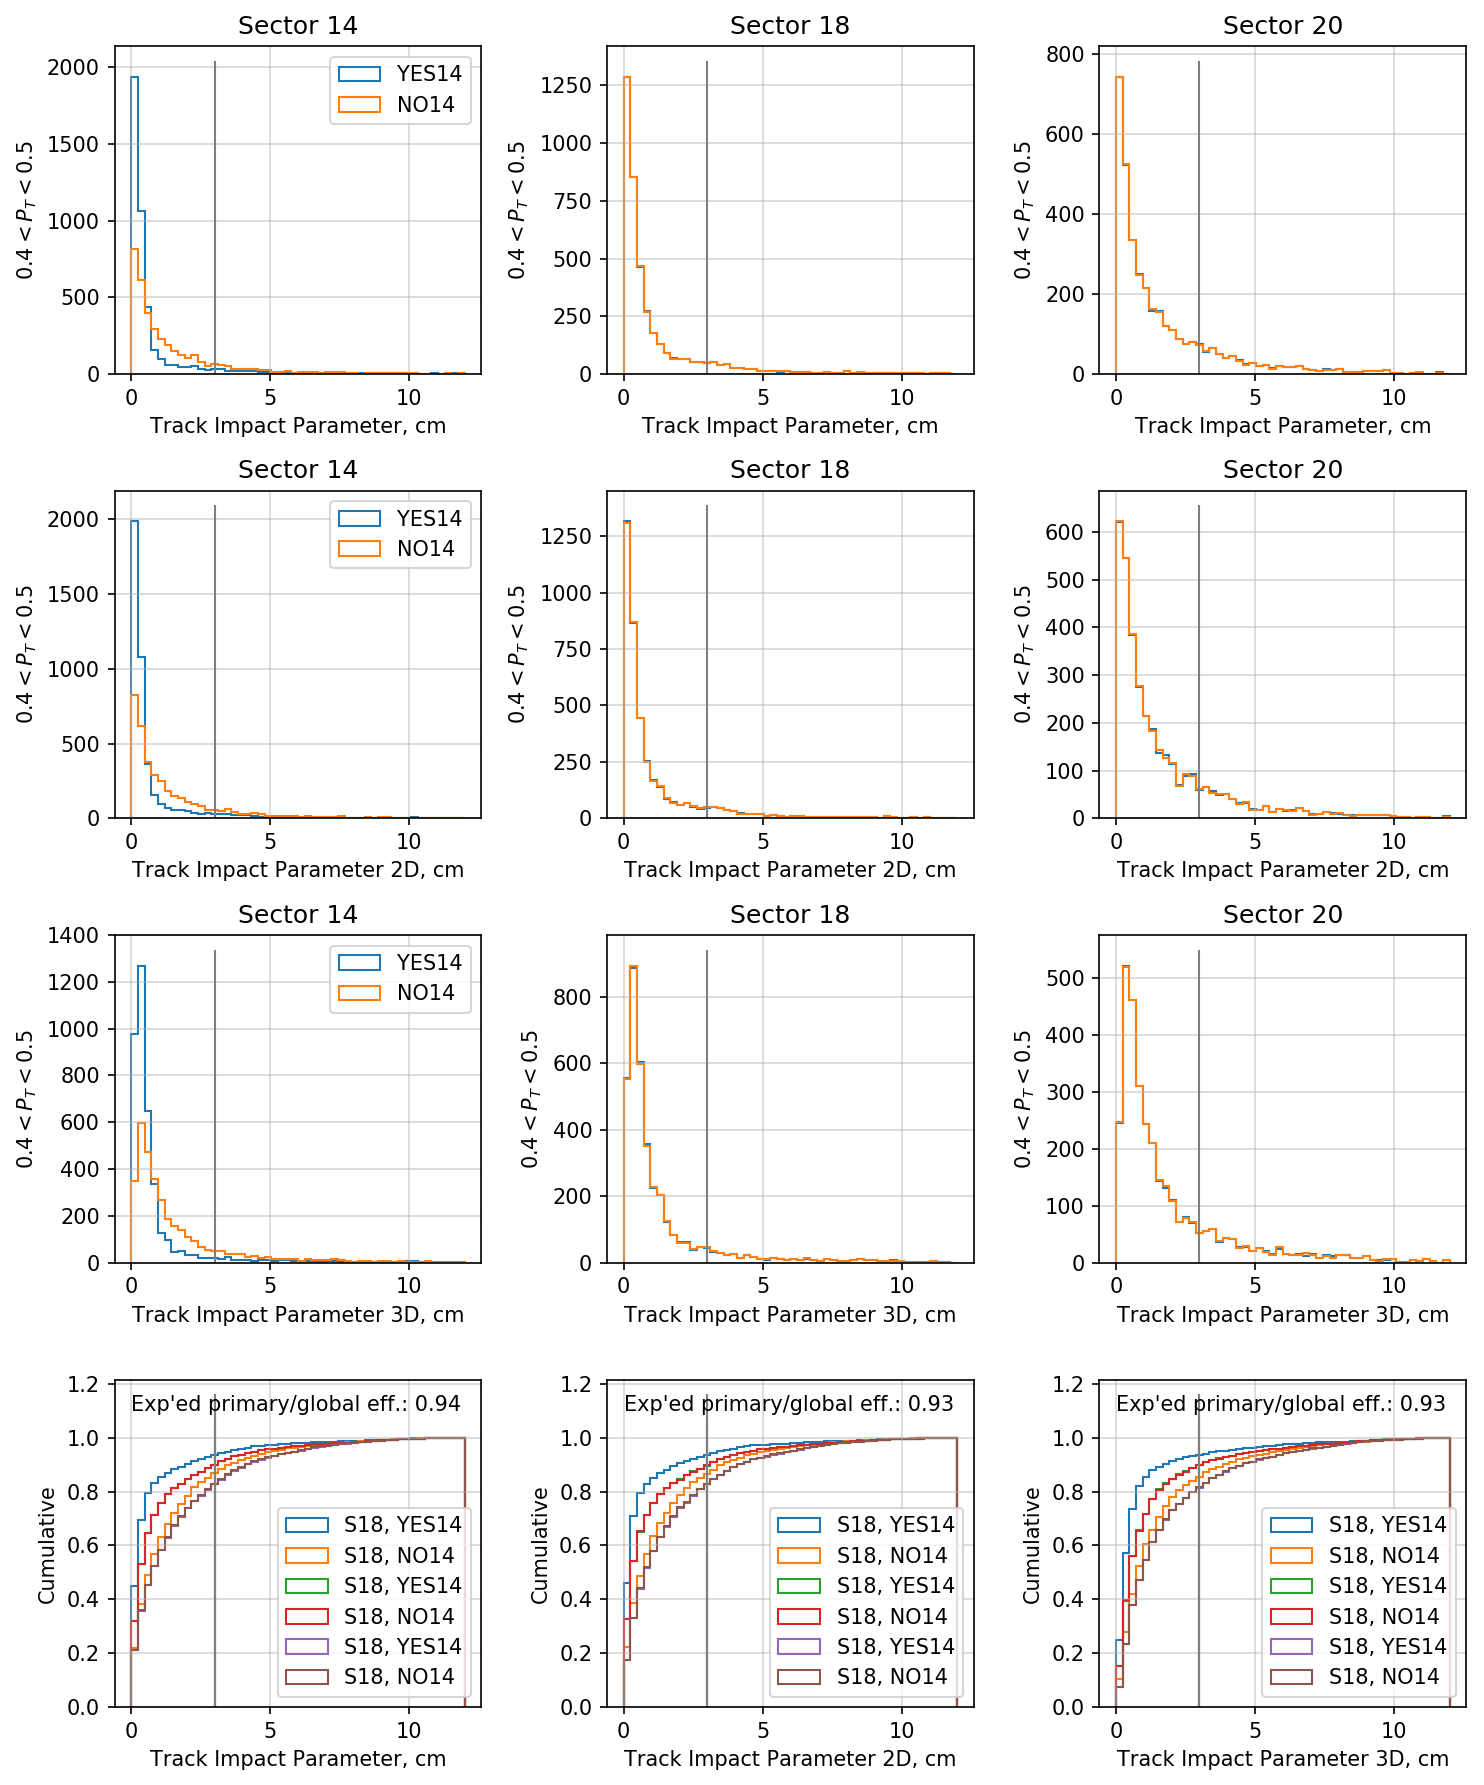

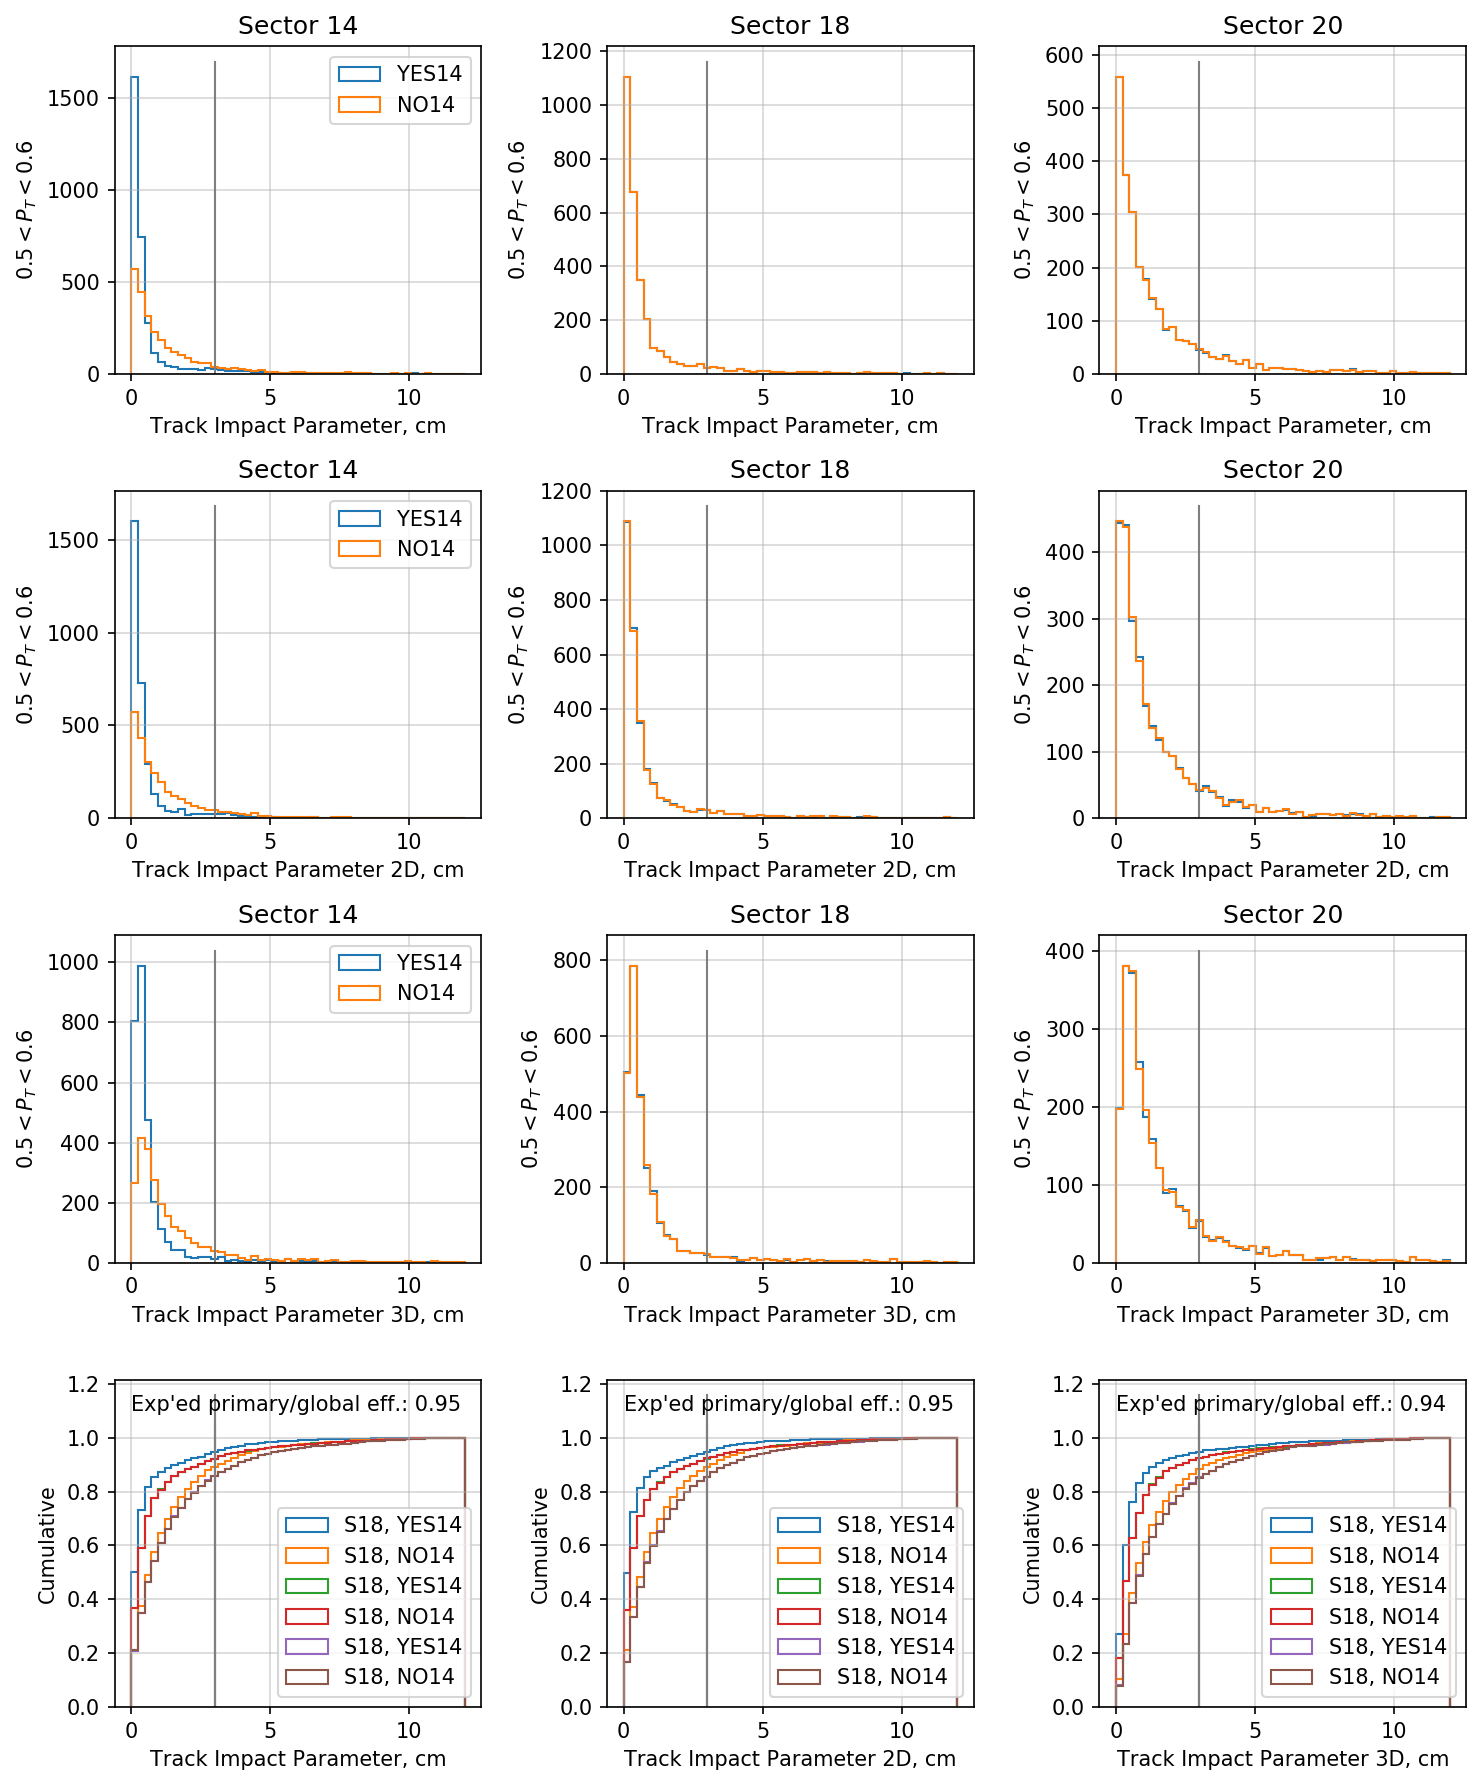

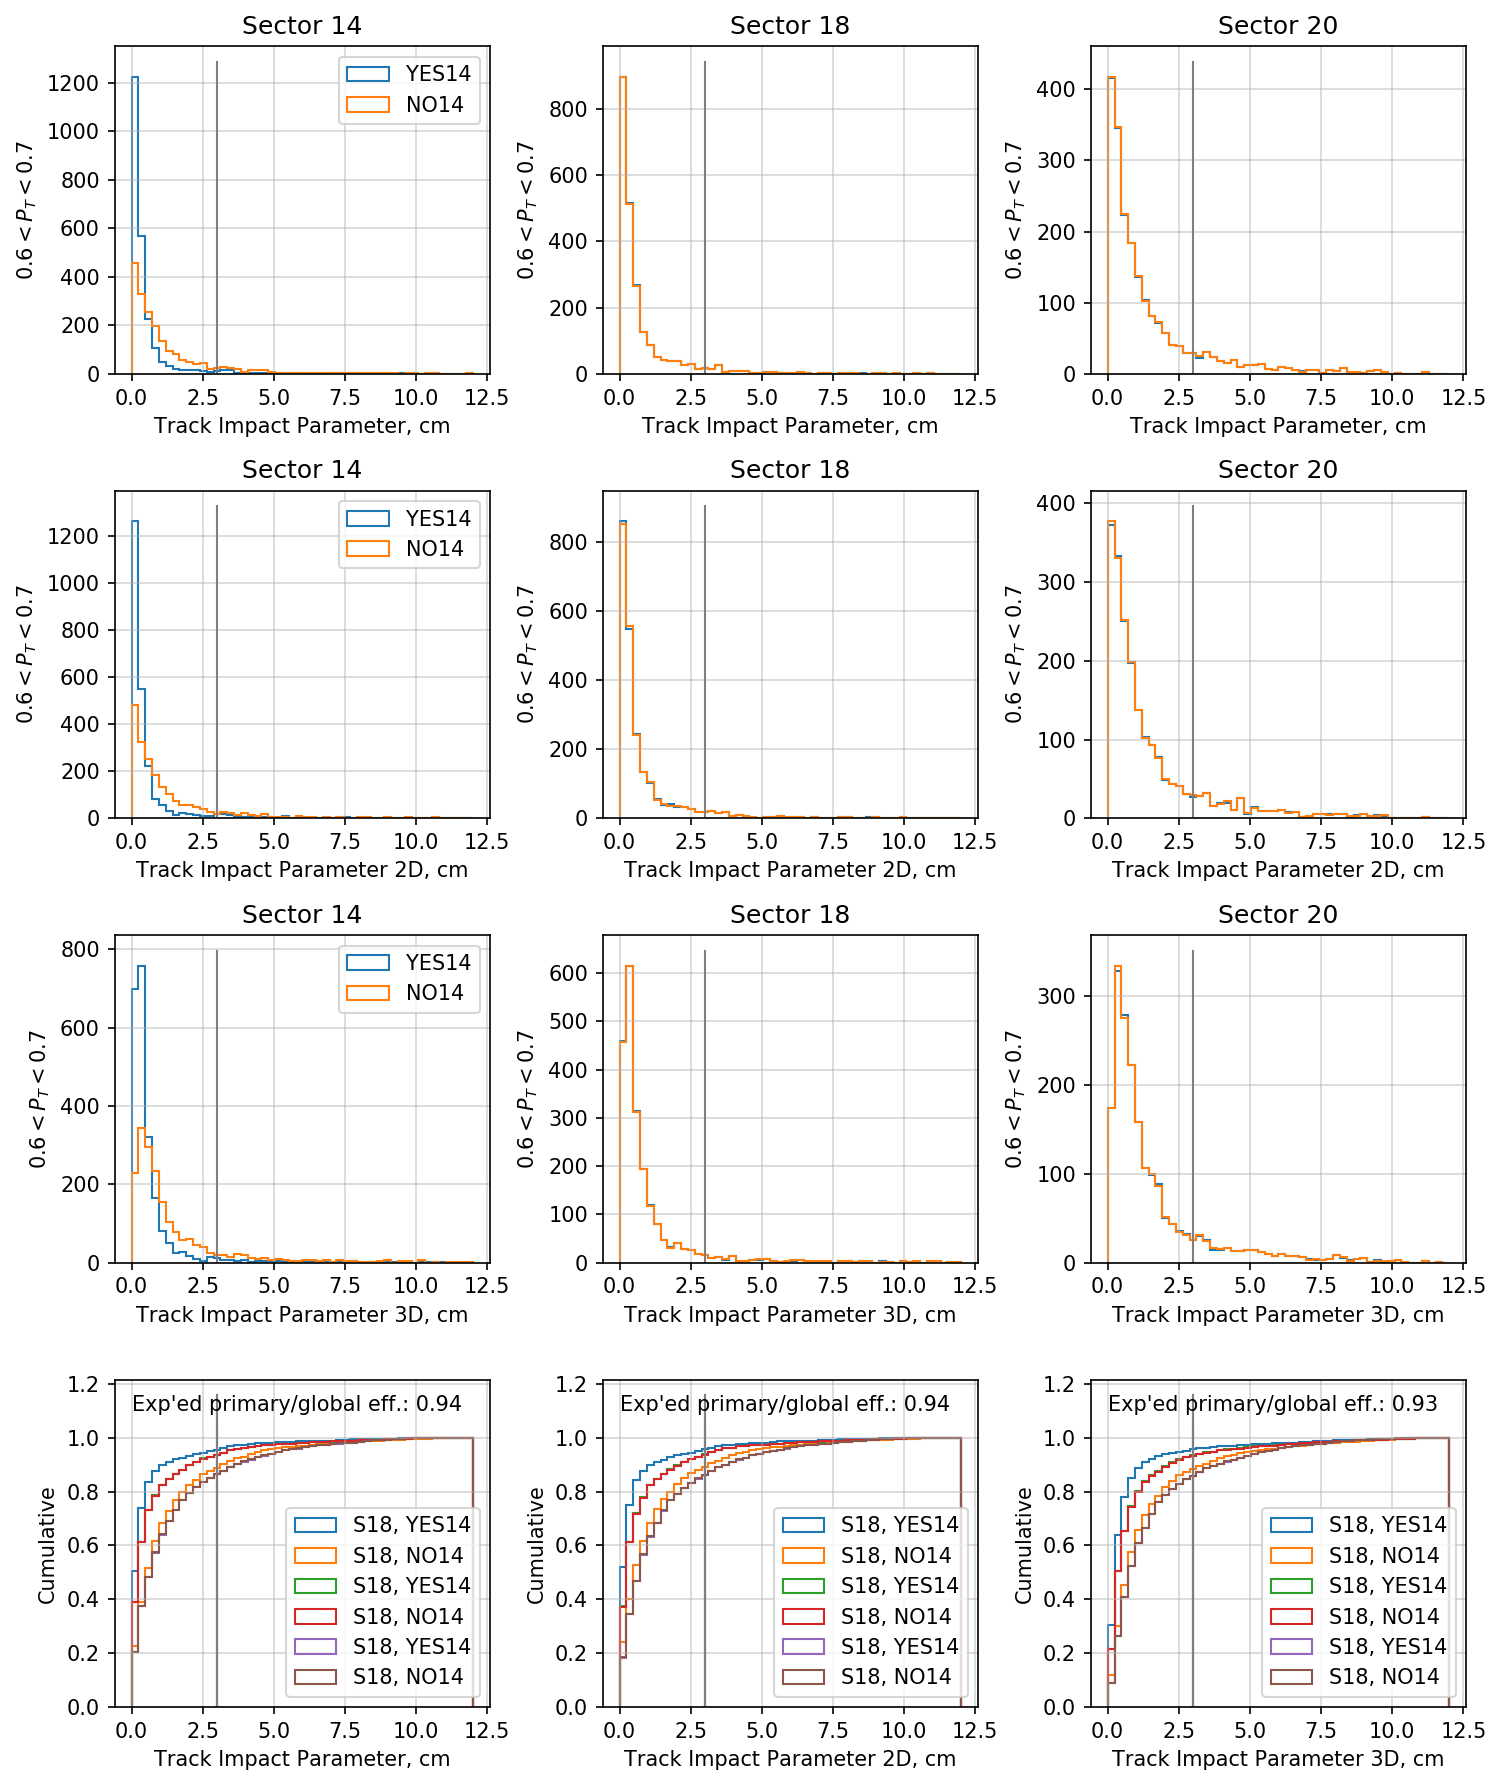

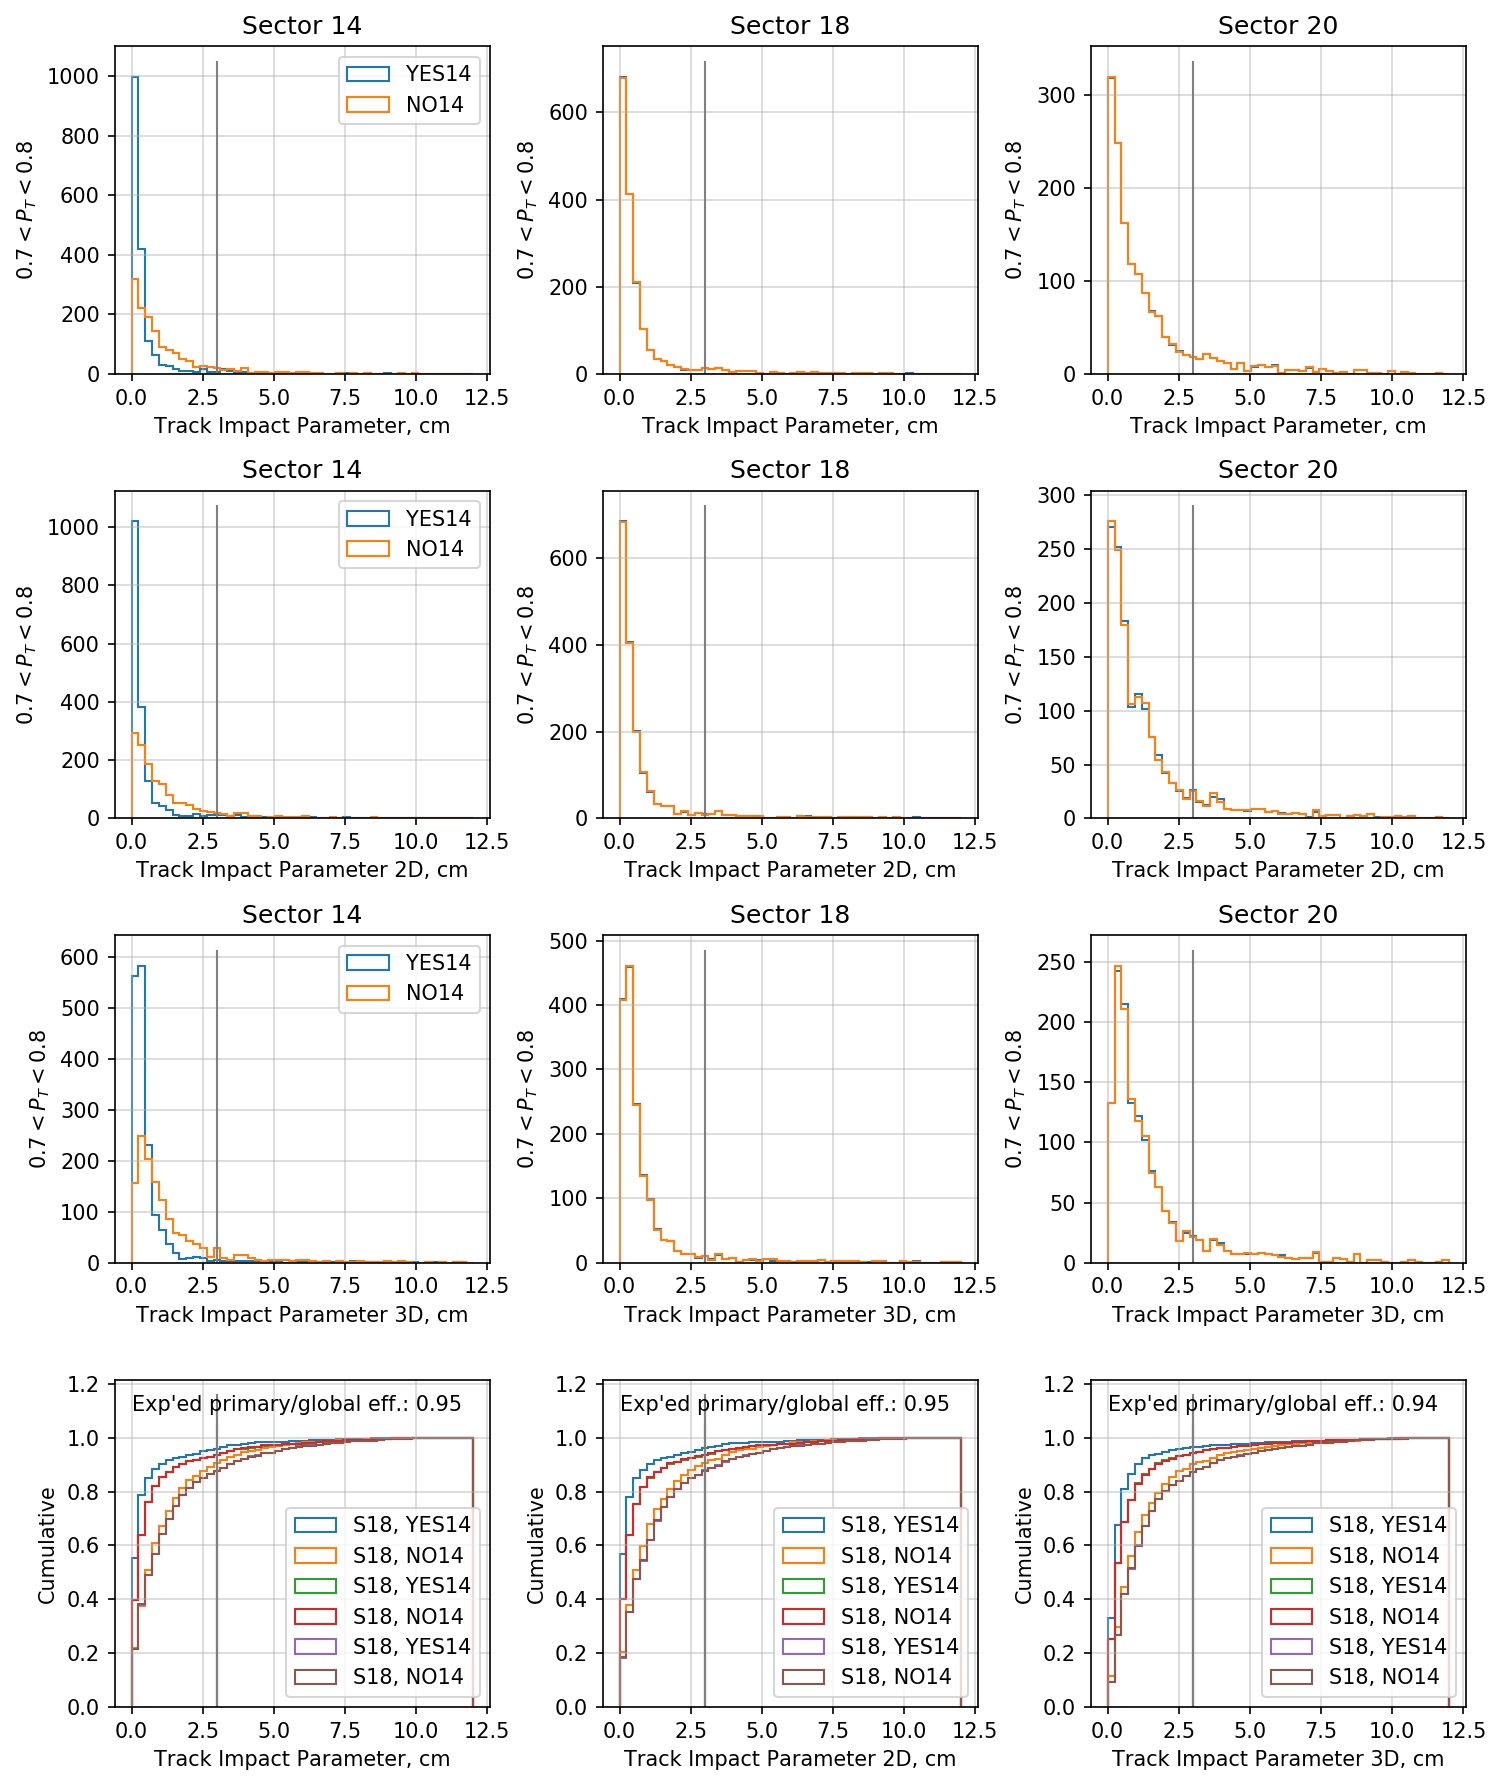

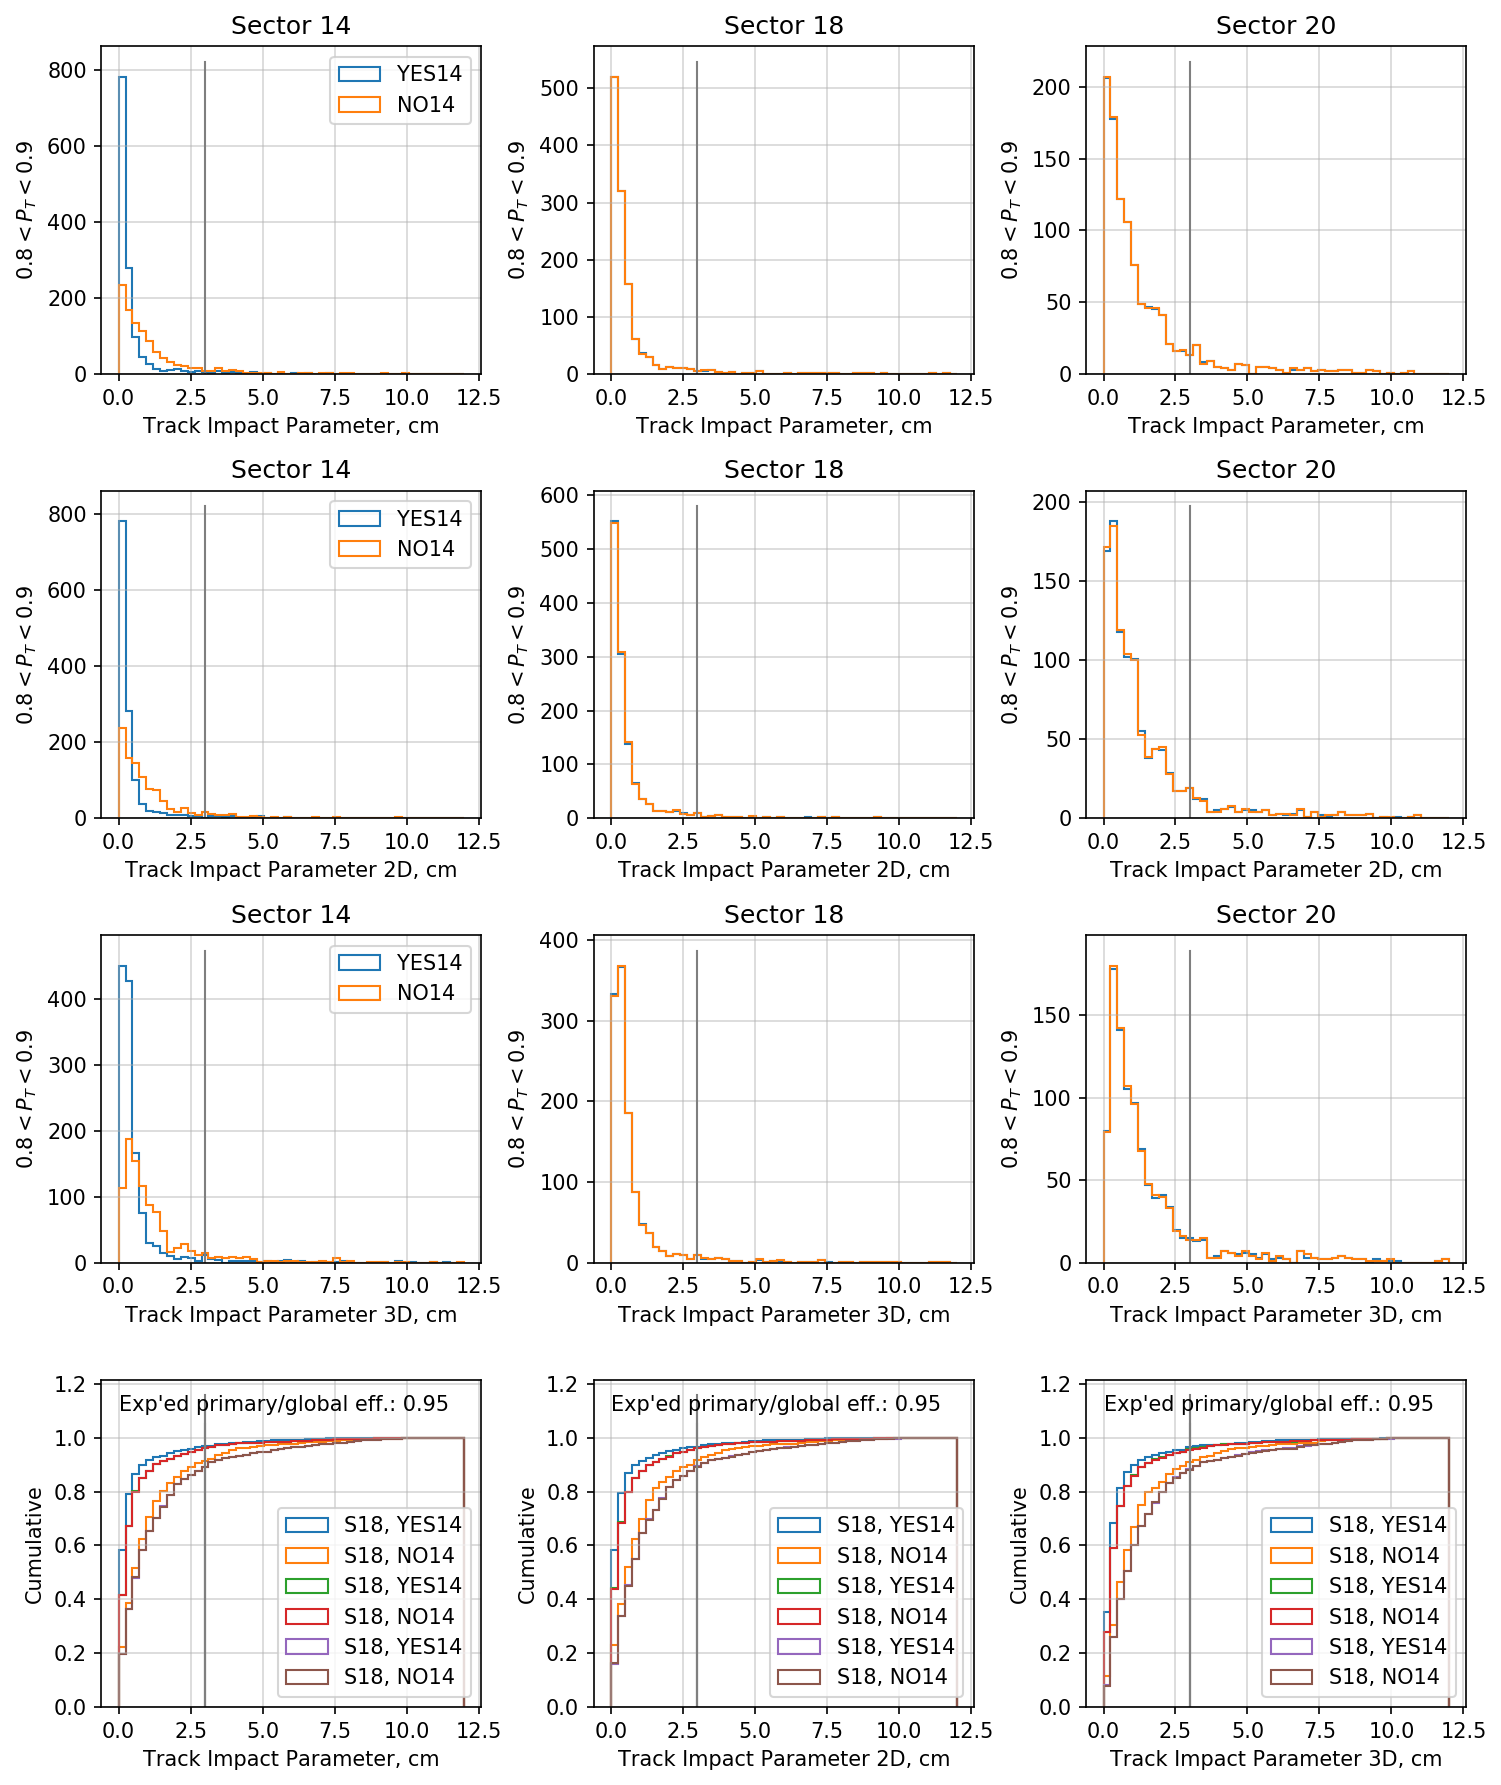

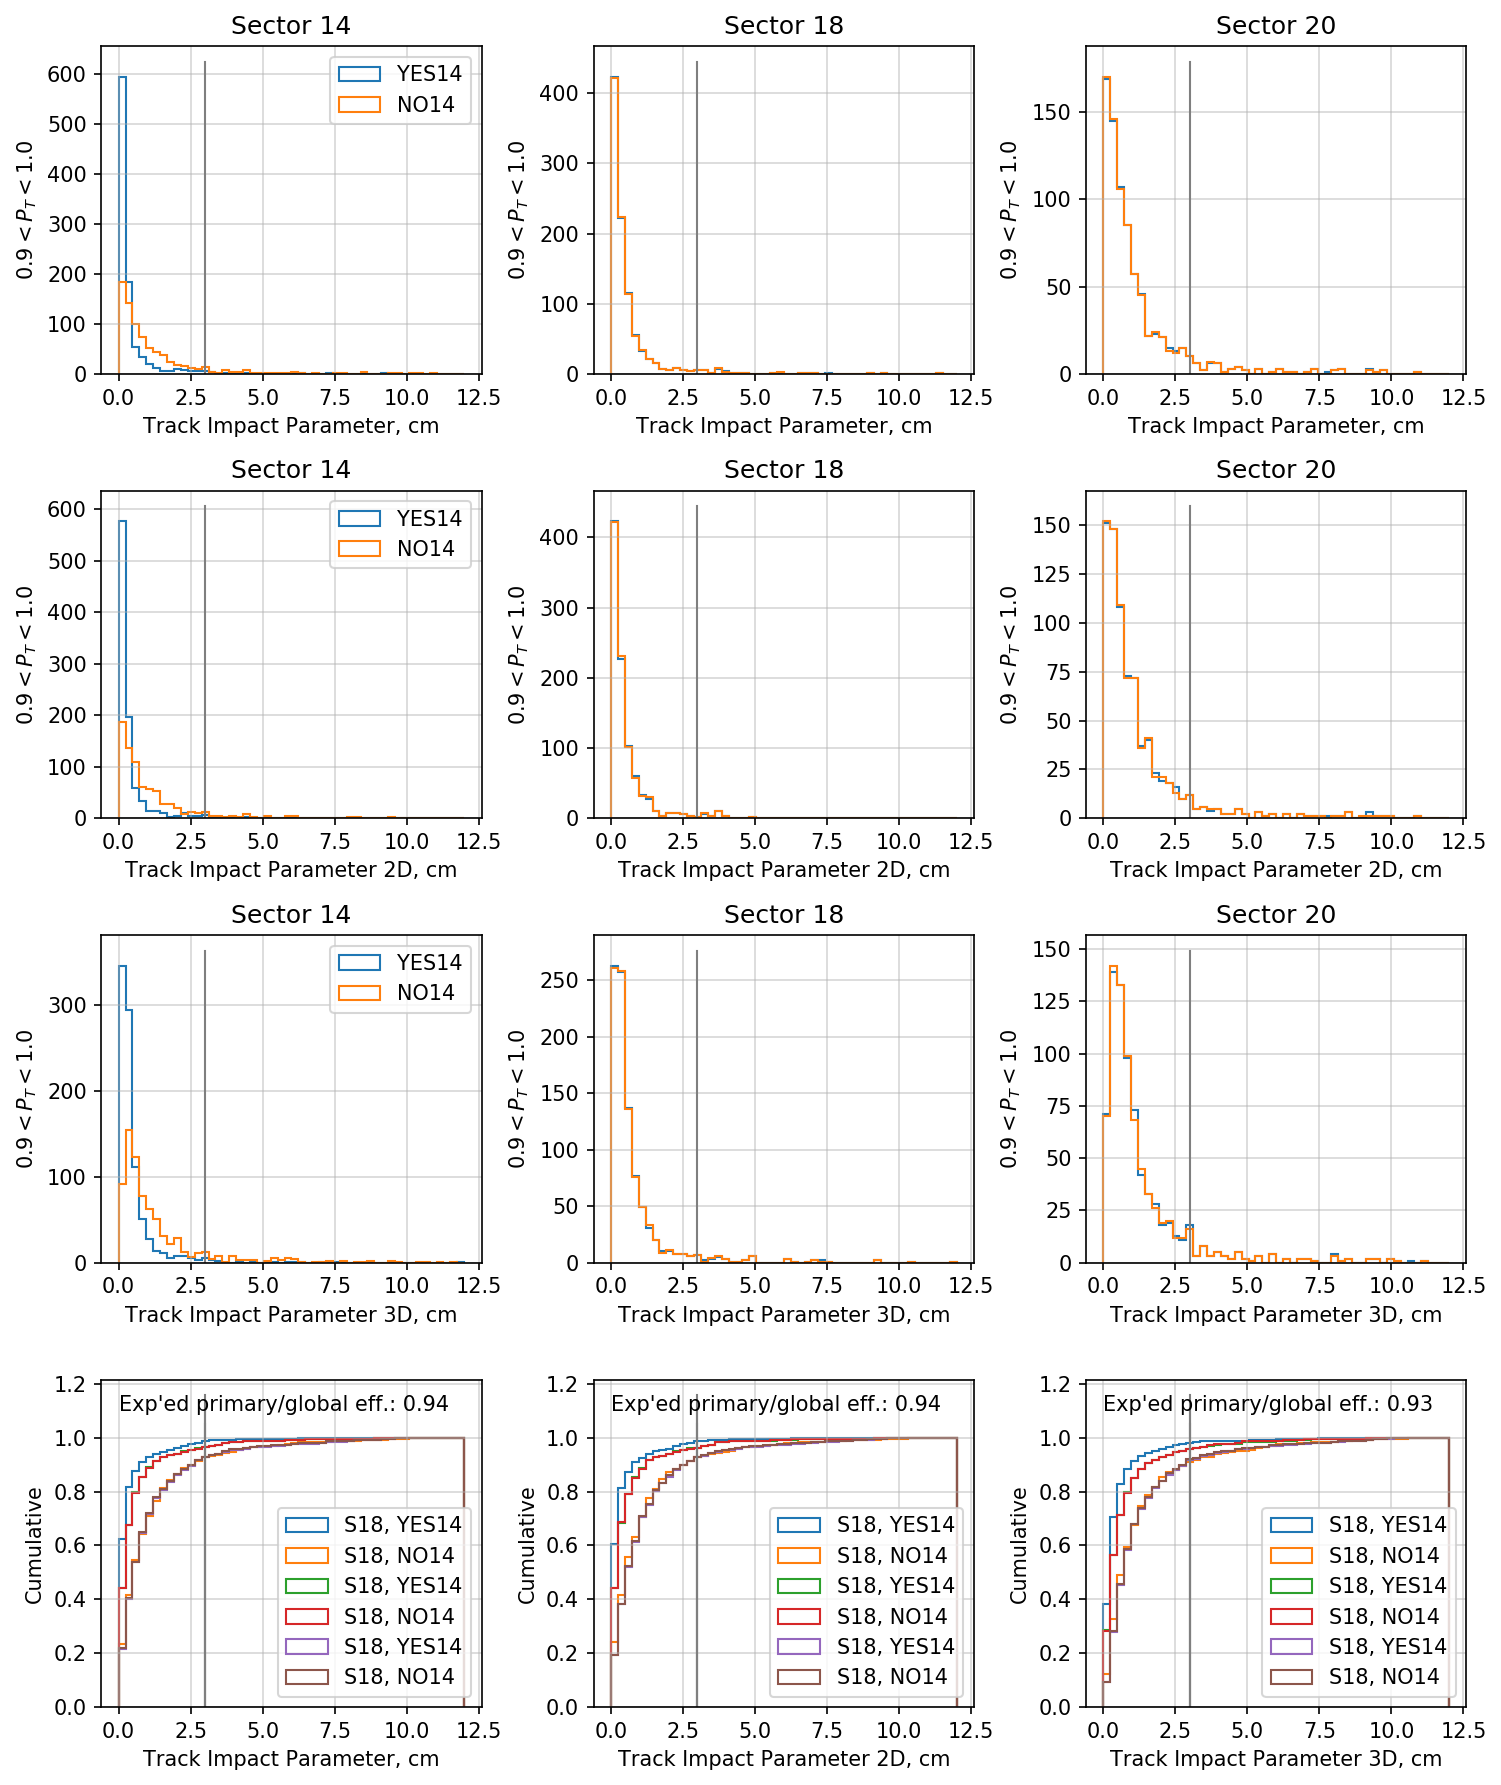

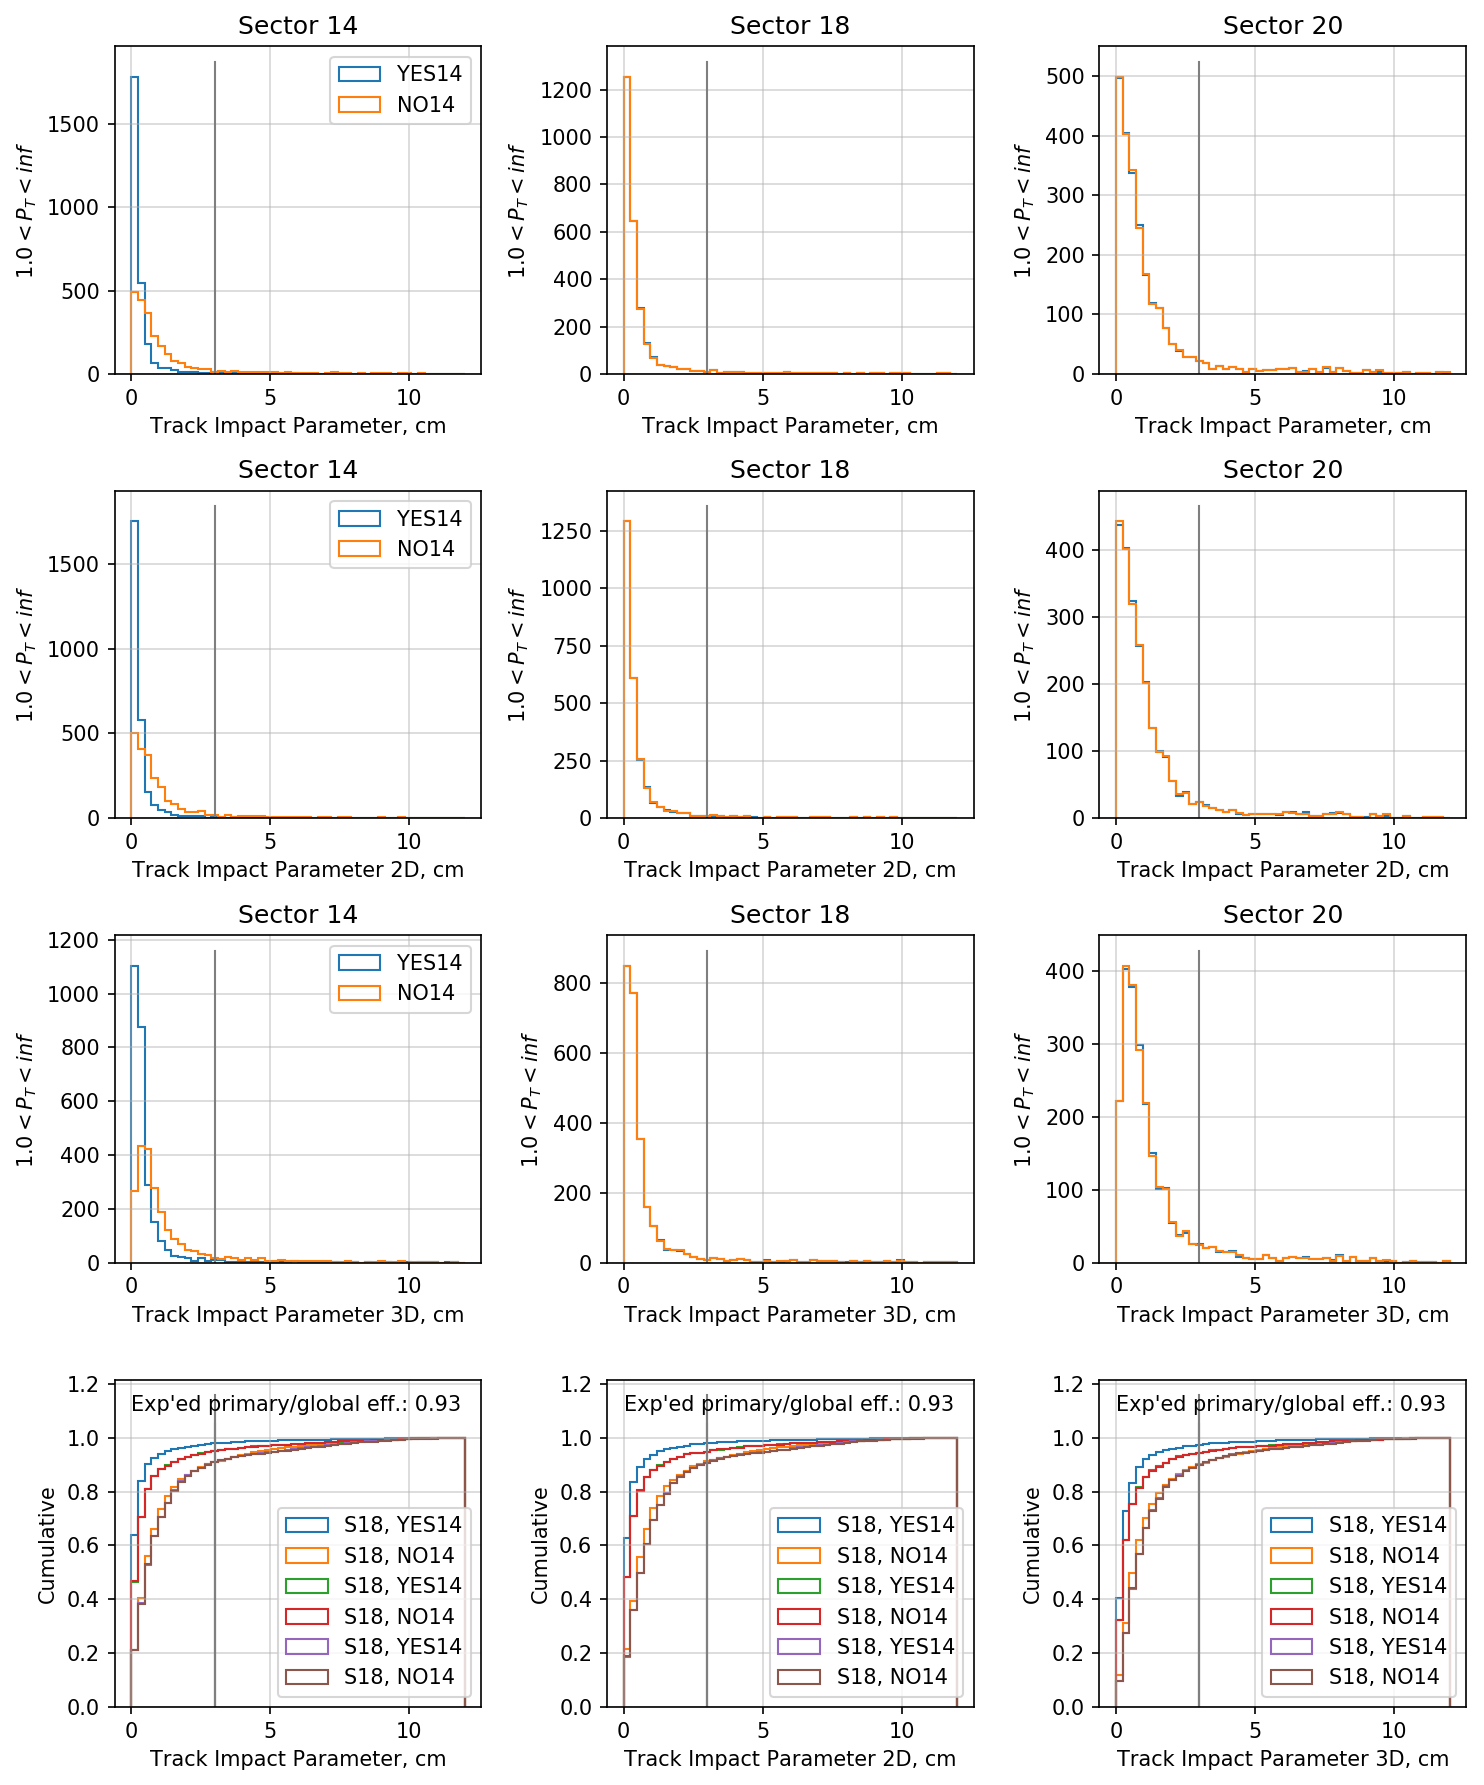

In [16]:
h_kwargs   = dict(bins=np.linspace(0, 12, 51), histtype='step')
h_kwargs_c = dict(bins=np.linspace(0, 12, 51), histtype='step', cumulative=True, density=True)

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
 
    fig, ax = plt.subplots(4, 3, figsize=(10, 4*3))

    # Sectors 14, 18, 20
    plot_YN('imp',   ax[0, 0], ax[3, 0], i, 14, True,  h_kwargs, h_kwargs_c)
    plot_YN('imp',   ax[0, 1], ax[3, 0], i, 18, False, h_kwargs, h_kwargs_c)
    plot_YN('imp',   ax[0, 2], ax[3, 0], i, 20, False, h_kwargs, h_kwargs_c)
    
    plot_YN('imp2d', ax[1, 0], ax[3, 1], i, 14, True,  h_kwargs, h_kwargs_c)
    plot_YN('imp2d', ax[1, 1], ax[3, 1], i, 18, False, h_kwargs, h_kwargs_c)
    plot_YN('imp2d', ax[1, 2], ax[3, 1], i, 20, False, h_kwargs, h_kwargs_c)
    
    plot_YN('imp3d', ax[2, 0], ax[3, 2], i, 14, True,  h_kwargs, h_kwargs_c)
    plot_YN('imp3d', ax[2, 1], ax[3, 2], i, 18, False, h_kwargs, h_kwargs_c)
    plot_YN('imp3d', ax[2, 2], ax[3, 2], i, 20, False, h_kwargs, h_kwargs_c)
    
    plt.tight_layout()
    #plt.subplots_adjust(hspace=0.05)
    plt.savefig(f'graphics/imp_pt_bin_{i}.png', bbox_inches='tight', pad_inches=0.1)

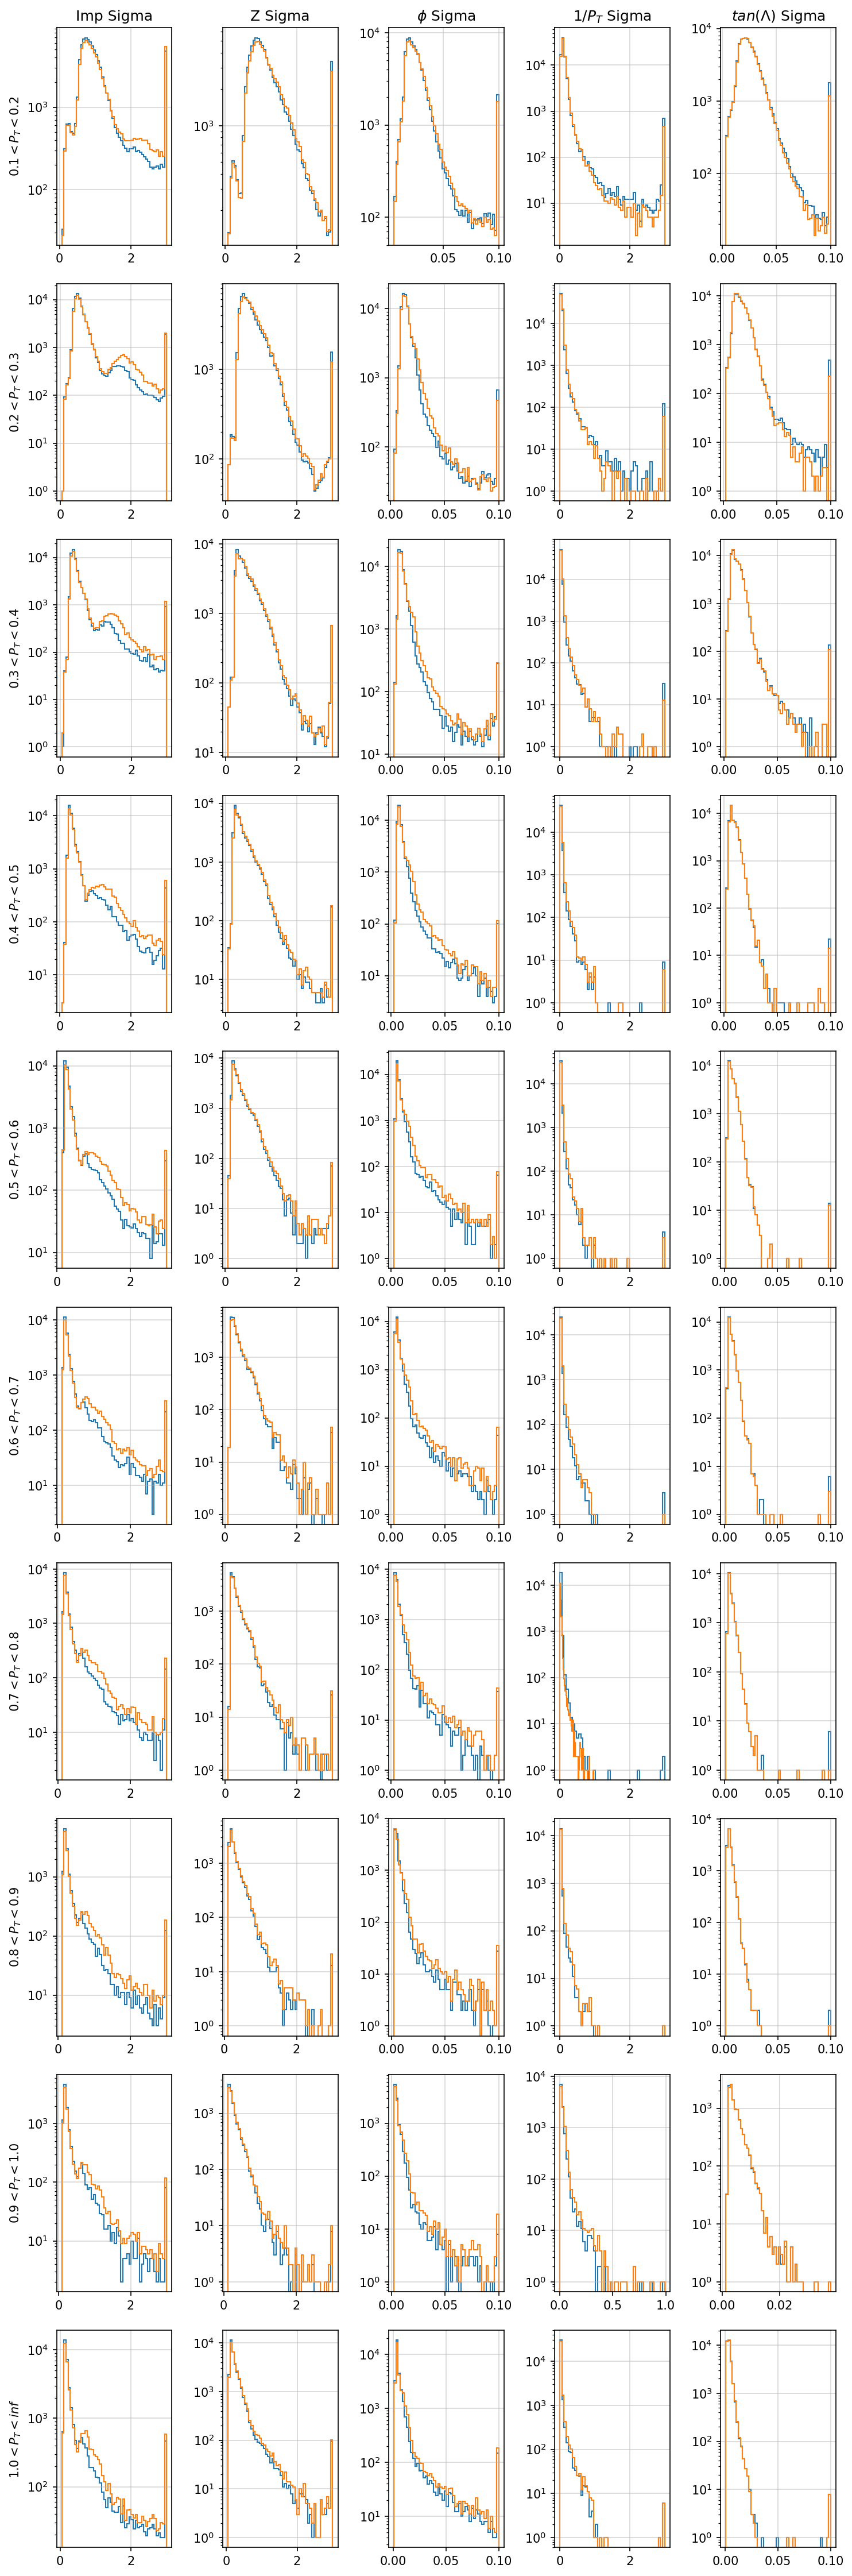

In [17]:
fig, ax = plt.subplots(nbins_pt, 5, figsize=(10, 3*nbins_pt))#, sharex='col')

h_kwargs = dict(bins=50, histtype='step')

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
 
    select_Y = points_east_Y & in_pt_bin_Y[i]
    select_N = points_east_N & in_pt_bin_N[i]

    a = ax[i, 0]
    a.hist(df_Y.loc[ select_Y ]['sigma[0]'], label='Y14', **h_kwargs)
    a.hist(df_N.loc[ select_N ]['sigma[0]'], label='N14', **h_kwargs)
    a.set_title('Imp Sigma') if i == 0 else None
    a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.grid()
    a.set_yscale('log')
    
    a = ax[i, 1]
    a.hist(df_Y.loc[ select_Y ]['sigma[1]'], label='Y14', **h_kwargs)
    a.hist(df_N.loc[ select_N ]['sigma[1]'], label='N14', **h_kwargs)
    a.set_title('Z Sigma') if i == 0 else None
    a.grid()
    a.set_yscale('log')
    
    a = ax[i, 2]
    a.hist(df_Y.loc[ select_Y ]['sigma[2]'], label='Y14', **h_kwargs)
    a.hist(df_N.loc[ select_N ]['sigma[2]'], label='N14', **h_kwargs)
    a.set_title('$\phi$ Sigma') if i == 0 else None
    a.grid()
    a.set_yscale('log')
    
    a = ax[i, 3]
    a.hist(df_Y.loc[ select_Y ]['sigma[3]'], label='Y14', **h_kwargs)
    a.hist(df_N.loc[ select_N ]['sigma[3]'], label='N14', **h_kwargs)
    a.set_title('$1/P_T$ Sigma') if i == 0 else None
    a.grid()
    a.set_yscale('log')
    
    a = ax[i, 4]
    a.hist(df_Y.loc[ select_Y ]['sigma[4]'], label='Y14', **h_kwargs)
    a.hist(df_N.loc[ select_N ]['sigma[4]'], label='N14', **h_kwargs)
    a.set_title('$tan(\Lambda)$ Sigma') if i == 0 else None
    a.grid()
    a.set_yscale('log')
    
fig.tight_layout()
plt.show()

## Number of hits on tracks

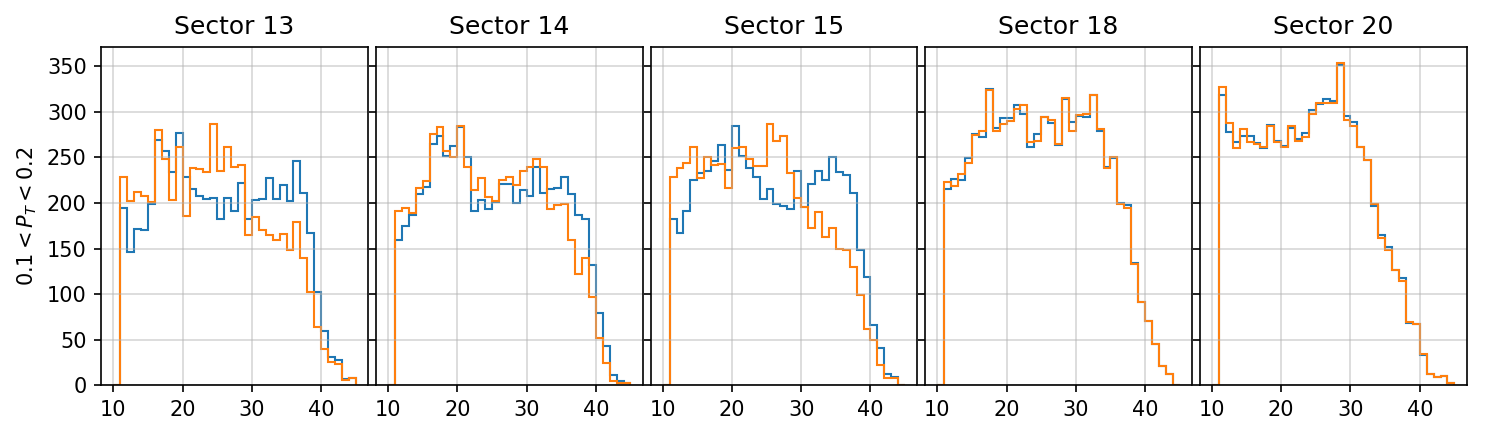

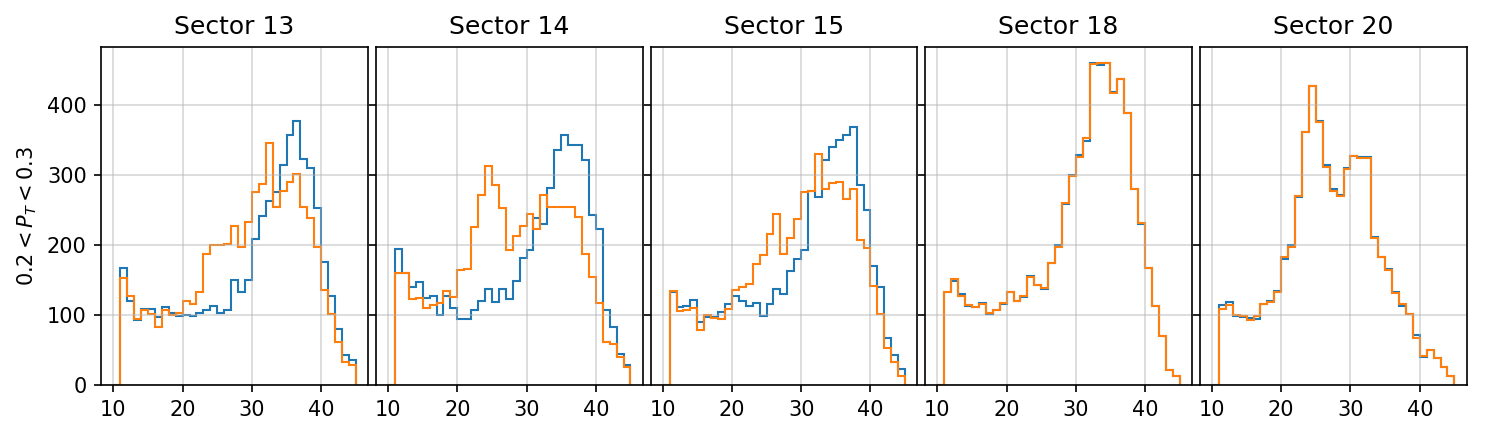

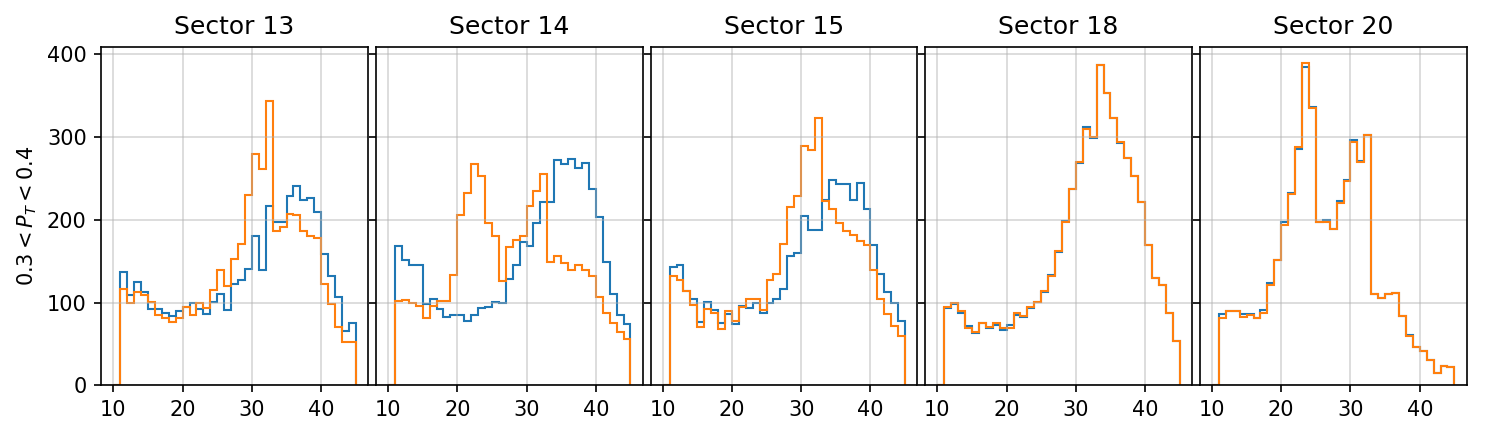

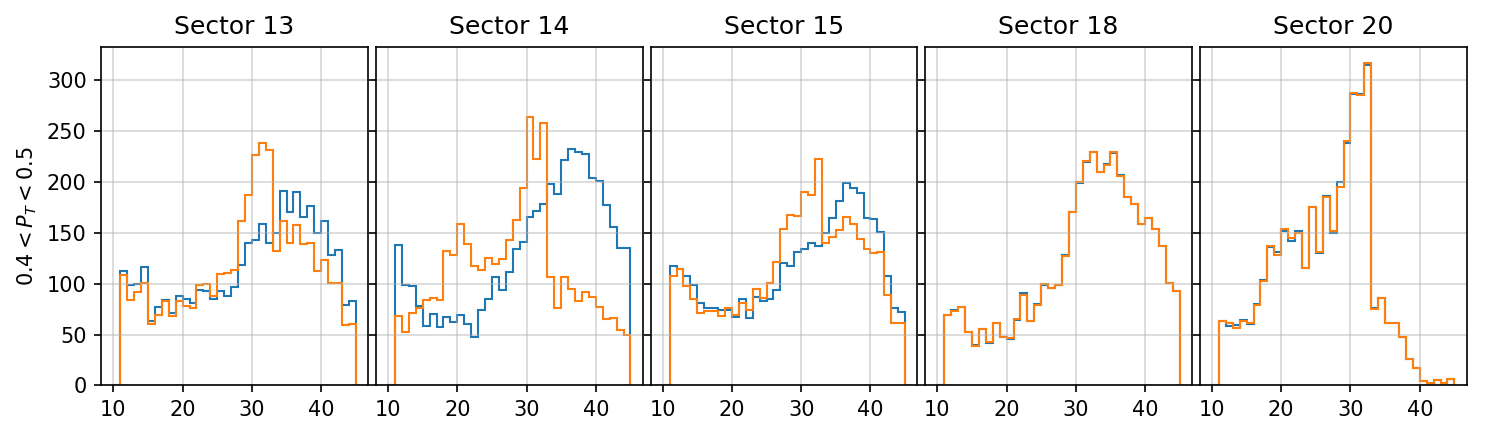

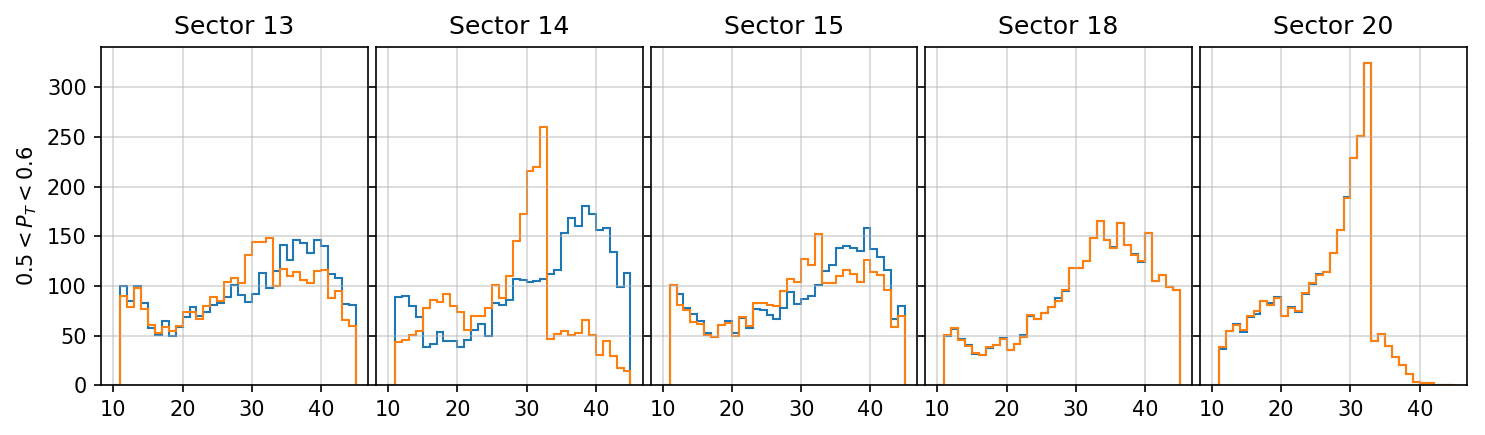

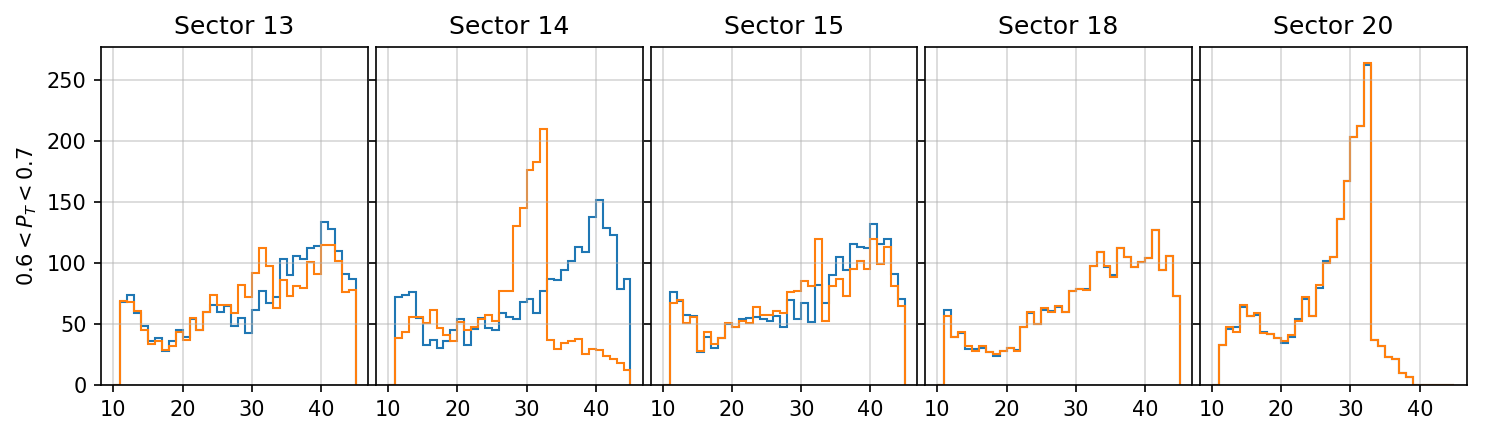

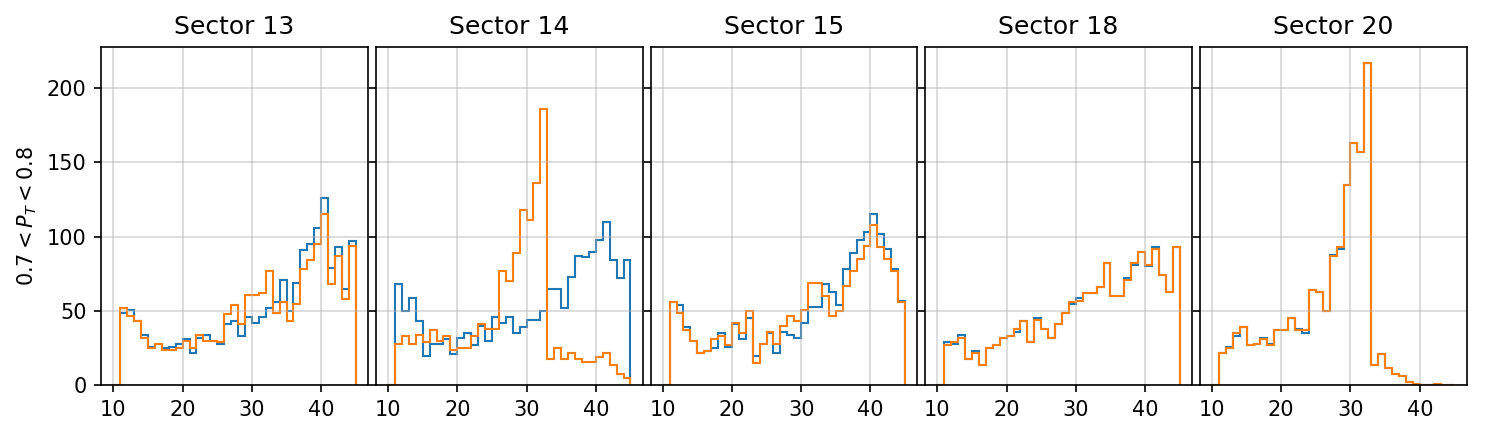

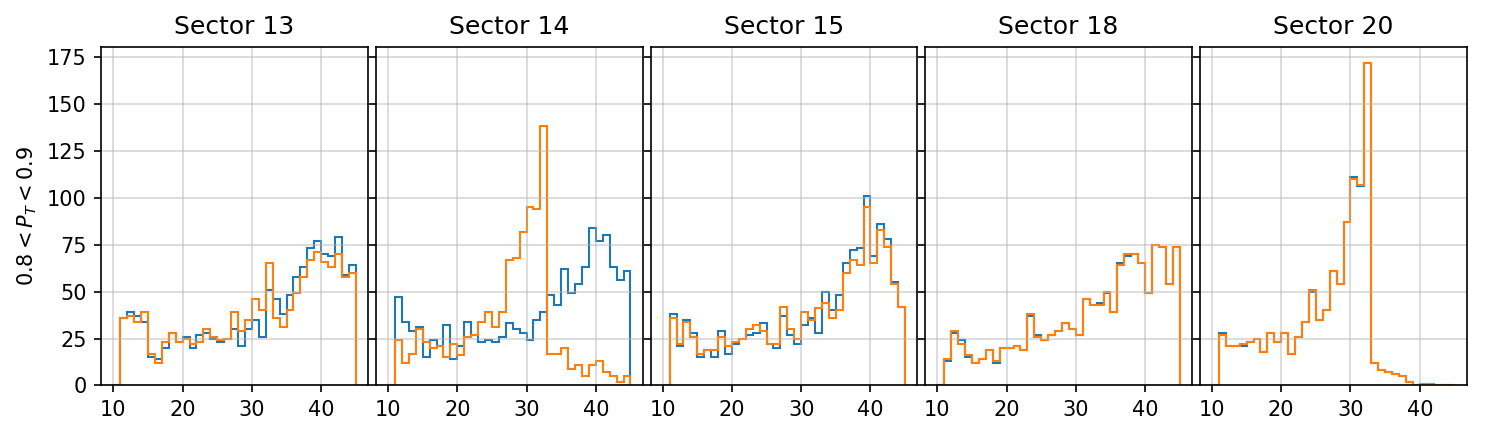

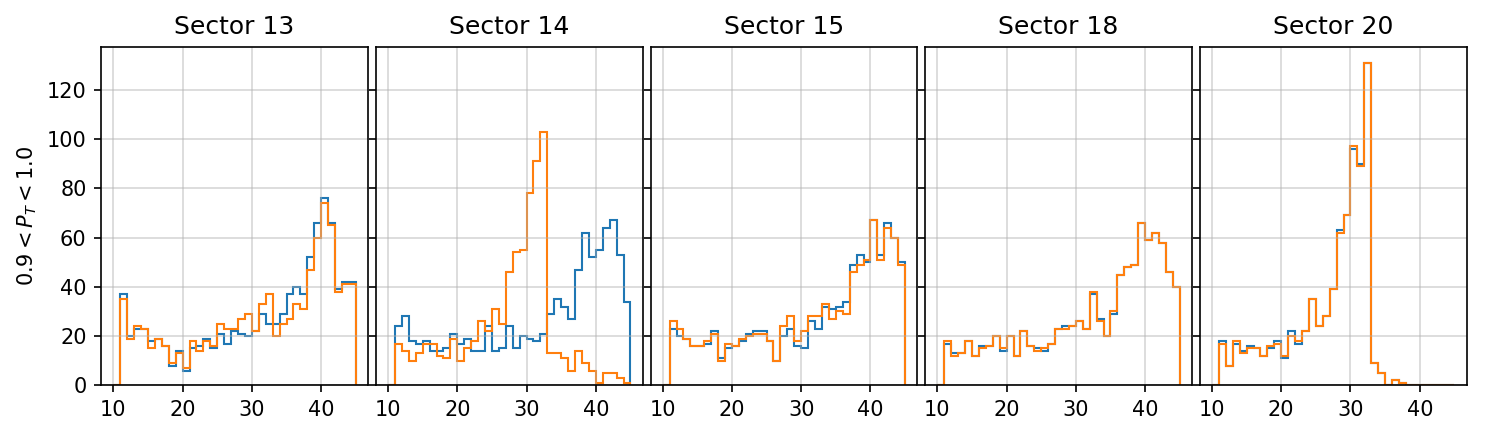

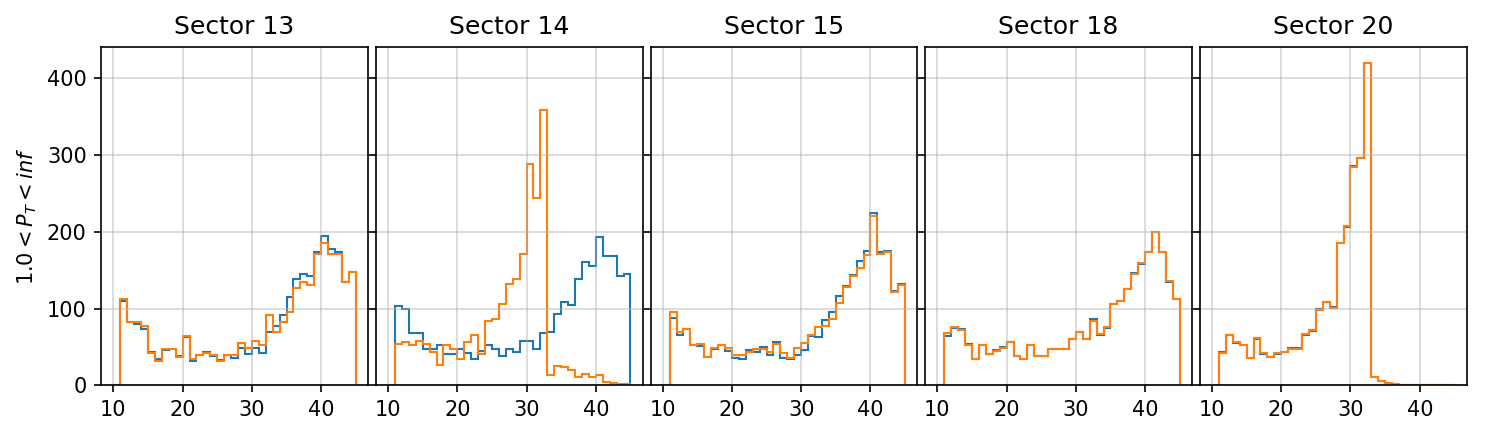

In [18]:
h_kwargs = dict(bins=np.linspace(10, 45, 36), histtype='step')

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    
    fig, ax = plt.subplots(1, 5, figsize=(10, 3), sharey='row')
    
    select_pt_Y = points_east_Y & in_pt_bin_Y[i]
    select_pt_N = points_east_N & in_pt_bin_N[i]
    
    select_Y = select_pt_Y & in_sector(df_Y, 13)
    select_N = select_pt_N & in_sector(df_N, 13)

    a = ax[0]
    a.hist(abs(df_Y.loc[ select_Y ].nhits), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ].nhits), label='NO14', **h_kwargs)
    a.set_title('Sector 13')
    a.set_ylabel(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.grid()
    
    select_Y = select_pt_Y & in_sector(df_Y, 14)
    select_N = select_pt_N & in_sector(df_N, 14)

    a = ax[1]
    a.hist(abs(df_Y.loc[ select_Y ].nhits), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ].nhits), label='NO14', **h_kwargs)
    a.set_title('Sector 14')
    a.grid()
    
    select_Y = select_pt_Y & in_sector(df_Y, 15)
    select_N = select_pt_N & in_sector(df_N, 15)

    a = ax[2]
    a.hist(abs(df_Y.loc[ select_Y ].nhits), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ].nhits), label='NO14', **h_kwargs)
    a.set_title('Sector 15')
    a.grid()
    
    select_Y = select_pt_Y & in_sector(df_Y, 18)
    select_N = select_pt_N & in_sector(df_N, 18)

    a = ax[3]
    a.hist(abs(df_Y.loc[ select_Y ].nhits), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ].nhits), label='NO14', **h_kwargs)
    a.set_title('Sector 18')
    a.grid()
    
    select_Y = select_pt_Y & in_sector(df_Y, 20)
    select_N = select_pt_N & in_sector(df_N, 20)

    a = ax[4]
    a.hist(abs(df_Y.loc[ select_Y ].nhits), label='YES14', **h_kwargs)
    a.hist(abs(df_N.loc[ select_N ].nhits), label='NO14', **h_kwargs)
    a.set_title('Sector 20')
    a.grid()

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.01, wspace=0.03)
    plt.savefig(f'graphics/nhits_pt_bin_{i}.png', bbox_inches='tight', pad_inches=0.1)

## Summary

- We consider tracks in the TPC sweet spot

- Hits missing in inner TPC layers affect both global and primary tracks
- High $P_T$ tracks: Loss of $\sim 20\%$ is expected
- Low $P_T$ tracks anomaly: More tracks are reconstructed in the neighboring sectors
- In addition a few percent drop ($\sim$ 7\%) in primary tracks is expected across all $P_T$ values